# TCAV — Text 


In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"  # silence + disable rust-tokenizers threadpool

In [2]:
# --- local import shim ---
import sys, pathlib
for p in (pathlib.Path.cwd().parent / "src", pathlib.Path.cwd().parents[1] / "src"):
    if (p / "tcavlab").exists():
        sys.path.insert(0, str(p))
try:
    import tcavlab  # noqa: F401
    print("Imported tcavlab from a local ../src path.")
except ModuleNotFoundError as e:
    raise ModuleNotFoundError("Could not import tcavlab. Keep notebooks/ and src/ side by side, or pip install -e .") from e


Imported tcavlab from a local ../src path.


In [3]:
import sys, importlib
import transformers, tokenizers, torch
print("transformers:", transformers.__version__, "@", transformers.__file__)
print("tokenizers:", tokenizers.__version__)
print("torch:", torch.__version__)
import tcavlab.models.text as tx
importlib.reload(tx)  # ensure the module sees transformers now
from tcavlab.models.text import choose_text_model

transformers: 4.56.1 @ /Users/juliawenkmann/miniconda3/envs/tcav_text/lib/python3.9/site-packages/transformers/__init__.py
tokenizers: 0.22.0
torch: 2.5.1


In [4]:

import os, numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
from tcavlab import (
    ExperimentConfig, DatasetConfig,
    plot_variance_vs_n, plot_tcav_score_variance,
    precompute_cavs_for_layer,
)
from tcavlab.cache import save_df_bundle, try_load_df_bundle
from tcavlab.utils import device_auto, set_all_seeds, ensure_dir
from tcavlab.datasets.text import load_texts
from tcavlab.models.text import available_text_models, choose_text_model, tokenize_texts
from tcavlab.activations import get_text_activations, get_text_gradients
from tcavlab.plots import plot_surround_assumption, plot_pca_projection
from tcavlab.assumptions import check_surround_assumption
from tcavlab.analysis_utils import (
    load_cav_vector_variance_data_cached,
    load_sensitivity_score_variance_data_cached,
    calculate_tcav_score_variance_cached,
)


In [5]:

# -----------------------------
# 1) Configuration
# -----------------------------
METHOD = "logistic"
MODEL = "distilbert-base-uncased-finetuned-sst-2-english"
print("Available text models:", available_text_models())

dataset = DatasetConfig(
    name="text",
    concepts=["positive-adjectives", "negative-adjectives", "neutral-adjectives"],  # adapt to your folders
    target_class_name="positive",
    target_class_index=1,
    data_paths={
        "concepts_root": "/Users/juliawenkmann/Documents/CodingProjects/tcav_projects/tcav_variability/src/tcavlab/datasets/TCAV_Text/concepts",
        "random_dir": "/Users/juliawenkmann/Documents/CodingProjects/tcav_projects/tcav_variability/src/tcavlab/datasets/TCAV_Text/random",
        "class_dir": "/Users/juliawenkmann/Documents/CodingProjects/tcav_projects/tcav_variability/src/tcavlab/datasets/TCAV_Text/target",
    },
)

cfg = ExperimentConfig(
    dataset=dataset,
    method=METHOD,
    model_key=MODEL,
    n_values=range(10, 310, 10),
    runs=10,
    sets_per_run=10,
    out_dir=f"artifacts/text/{MODEL}/{METHOD}",
    seed=42,
)

set_all_seeds(cfg.seed)
DEVICE = device_auto()
print("Using device:", DEVICE)

CACHE_DIR = os.path.join(cfg.out_dir, "cache")
LOAD_IF_EXISTS = False
os.makedirs(CACHE_DIR, exist_ok=True)


Available text models: ['distilbert-base-uncased-finetuned-sst-2-english', 'bert-base-uncased']
Using device: mps


In [6]:
# -----------------------------
# 2a) TorchText loading (your original style)
# -----------------------------
USE_TORCHTEXT_LOADING = True   # set False to revert to the previous simple loader

if USE_TORCHTEXT_LOADING:
    from tcavlab.datasets.text_torchtext import build_fields_and_vocab
    try:
        TEXT, Label = build_fields_and_vocab(
            concept_names=cfg.dataset.concepts,
            concepts_root=cfg.dataset.data_paths["concepts_root"],
            random_dir=cfg.dataset.data_paths["random_dir"],
            class_dir=cfg.dataset.data_paths["class_dir"],
            lower=True, pad_token="pad", unk_token="<unk>",  # matches your data
            use_label=False,  # set True if your CSV has labels as a second column
        )
        print("Vocab size:", len(TEXT.vocab))
    except AssertionError as e:
        raise ImportError("torchtext is required for this loading path. Install `torchtext` and restart the kernel.") from e
else:
    TEXT = Label = None


Vocab size: 3141


In [7]:

# -----------------------------
# 2b) Model & tokenizer
# -----------------------------
model, layer_indices, layer_names, tokenizer, device = choose_text_model(cfg.model_key, device=DEVICE)
print("Chosen hidden layers:", list(zip(layer_names, layer_indices)))


/Users/juliawenkmann/miniconda3/envs/tcav_text/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juliawenkmann/miniconda3/envs/tcav_text/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /Users/juliawenkmann/miniconda3/envs/tcav_text/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/juliawenkmann/miniconda3/envs/tcav_text/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/juliawenkmann/miniconda3/envs/tcav_text/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/juliawenkmann/miniconda3/envs/tcav_text/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/juliawenkmann/miniconda3/envs/tcav_text/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `

Chosen hidden layers: [('hidden_2', 2), ('hidden_4', 4), ('hidden_6', 6)]


In [8]:
# -----------------------------
# 3) Load text data
# -----------------------------
if USE_TORCHTEXT_LOADING:
    from tcavlab.datasets.text_torchtext import (
        collect_texts_from_concept, assemble_concept, indices_to_tokens, print_concept_sample
    )

    # Concepts -> turn index rows back into strings so we can feed HF
    concept_texts = {}
    for c in cfg.dataset.concepts:
        texts = collect_texts_from_concept(
            name=c,
            concepts_root=cfg.dataset.data_paths["concepts_root"],
            TEXT=TEXT, Label=Label,
            device=DEVICE, const_len=7,
        )
        concept_texts[c] = texts
        print(f"Loaded concept '{c}' with {len(texts)} texts; sample:", texts[:3])

    # Random
    rnd = assemble_concept(name="", id=0, concepts_path=cfg.dataset.data_paths["random_dir"],
                           TEXT=TEXT, Label=Label, device=DEVICE, const_len=7)["data_iter"]
    random_texts = []
    for batch in rnd:
        for row in batch:
            toks = indices_to_tokens(row, TEXT)
            if toks: random_texts.append(" ".join(toks))

    # Target class
    cls = assemble_concept(name="", id=0, concepts_path=cfg.dataset.data_paths["class_dir"],
                           TEXT=TEXT, Label=Label, device=DEVICE, const_len=7)["data_iter"]
    class_texts = []
    for batch in cls:
        for row in batch:
            toks = indices_to_tokens(row, TEXT)
            if toks: class_texts.append(" ".join(toks))

else:
    # (fallback) the earlier simple TXT-based loader
    from tcavlab.datasets.text import load_texts
    concept_texts = {}
    for c in cfg.dataset.concepts:
        concept_dir = os.path.join(cfg.dataset.data_paths["concepts_root"], c)
        concept_texts[c] = load_texts(concept_dir)
        print(f"Loaded concept '{c}' with {len(concept_texts[c])} docs")
    random_texts = load_texts(cfg.dataset.data_paths["random_dir"])
    print(cfg.dataset.data_paths["class_dir"])
    class_texts = load_texts(cfg.dataset.data_paths["class_dir"])

print("Loaded random:", len(random_texts), "target class:", len(class_texts))


Loaded concept 'positive-adjectives' with 120 texts; sample: ['. . so well . . .', '. . so good . . .', '. . . love it .']
Loaded concept 'negative-adjectives' with 120 texts; sample: ['. . so bad . . .', '. . so awful . . .', '. . . hate it .']
Loaded concept 'neutral-adjectives' with 120 texts; sample: ['. . the book . .', '. . a house . . .', '. was an object']
Loaded random: 749 target class: 30


In [9]:
shapes = []
for i in range(0, min(64, len(concept_texts["positive-adjectives"])), 16):
    enc = tokenize_texts(concept_texts["positive-adjectives"][i:i+16], tokenizer, max_length=128, device=DEVICE, pad="max_length")
    A = get_text_activations(model, enc, layer_indices[0])
    shapes.append(A.shape[1])
print("flattened dims per batch:", shapes)  # should all be identical (MAX_LEN * hidden_size)


flattened dims per batch: [98304, 98304, 98304, 98304]


In [10]:

# -----------------------------
# 4) Pre-compute activations and train CAVs
# -----------------------------
from math import ceil

def activations_from_texts(text_list, layer_index, batch_size=16):
    acts = []
    for i in range(0, len(text_list), batch_size):
        batch_texts = text_list[i:i+batch_size]
        enc = tokenize_texts(batch_texts, tokenizer, max_length=128, device=DEVICE, pad="max_length")
        A = get_text_activations(model, enc, layer_index)
        acts.append(A)
    import numpy as np
    return np.vstack(acts) if acts else np.zeros((0,0))

for layer_index, layer_name in zip(layer_indices, layer_names):
    for concept in cfg.dataset.concepts:
        print(f"Layer: {layer_name} — Concept: {concept}")
        pos_acts = activations_from_texts(concept_texts[concept], layer_index)
        neg_acts = activations_from_texts(random_texts, layer_index)
        base_dir = os.path.join(cfg.out_dir, layer_name, concept)
        ensure_dir(base_dir)
        precompute_cavs_for_layer(
            X_pos=pos_acts,
            X_neg=neg_acts,
            layer_name=layer_name,
            method=cfg.method,
            n_values=cfg.n_values,
            runs=cfg.runs,
            sets_per_run=cfg.sets_per_run,
            out_dir=base_dir,
            seed=cfg.seed,
        )
print("CAV precomputation done.")


Layer: hidden_2 — Concept: positive-adjectives
CAV file already exists, skipping: artifacts/text/distilbert-base-uncased-finetuned-sst-2-english/logistic/hidden_2/positive-adjectives/10/run_0.pkl
CAV file already exists, skipping: artifacts/text/distilbert-base-uncased-finetuned-sst-2-english/logistic/hidden_2/positive-adjectives/10/run_1.pkl
CAV file already exists, skipping: artifacts/text/distilbert-base-uncased-finetuned-sst-2-english/logistic/hidden_2/positive-adjectives/10/run_2.pkl
CAV file already exists, skipping: artifacts/text/distilbert-base-uncased-finetuned-sst-2-english/logistic/hidden_2/positive-adjectives/10/run_3.pkl
CAV file already exists, skipping: artifacts/text/distilbert-base-uncased-finetuned-sst-2-english/logistic/hidden_2/positive-adjectives/10/run_4.pkl
CAV file already exists, skipping: artifacts/text/distilbert-base-uncased-finetuned-sst-2-english/logistic/hidden_2/positive-adjectives/10/run_5.pkl
CAV file already exists, skipping: artifacts/text/distilber

Fit: $ 4.02/N \; + \; 0.121 $
Plot saved to artifacts/text/distilbert-base-uncased-finetuned-sst-2-english/logistic/plots/cav_vector_variance__distilbert-base-uncased-finetuned-sst-2-english_hidden_2_logistic.pdf


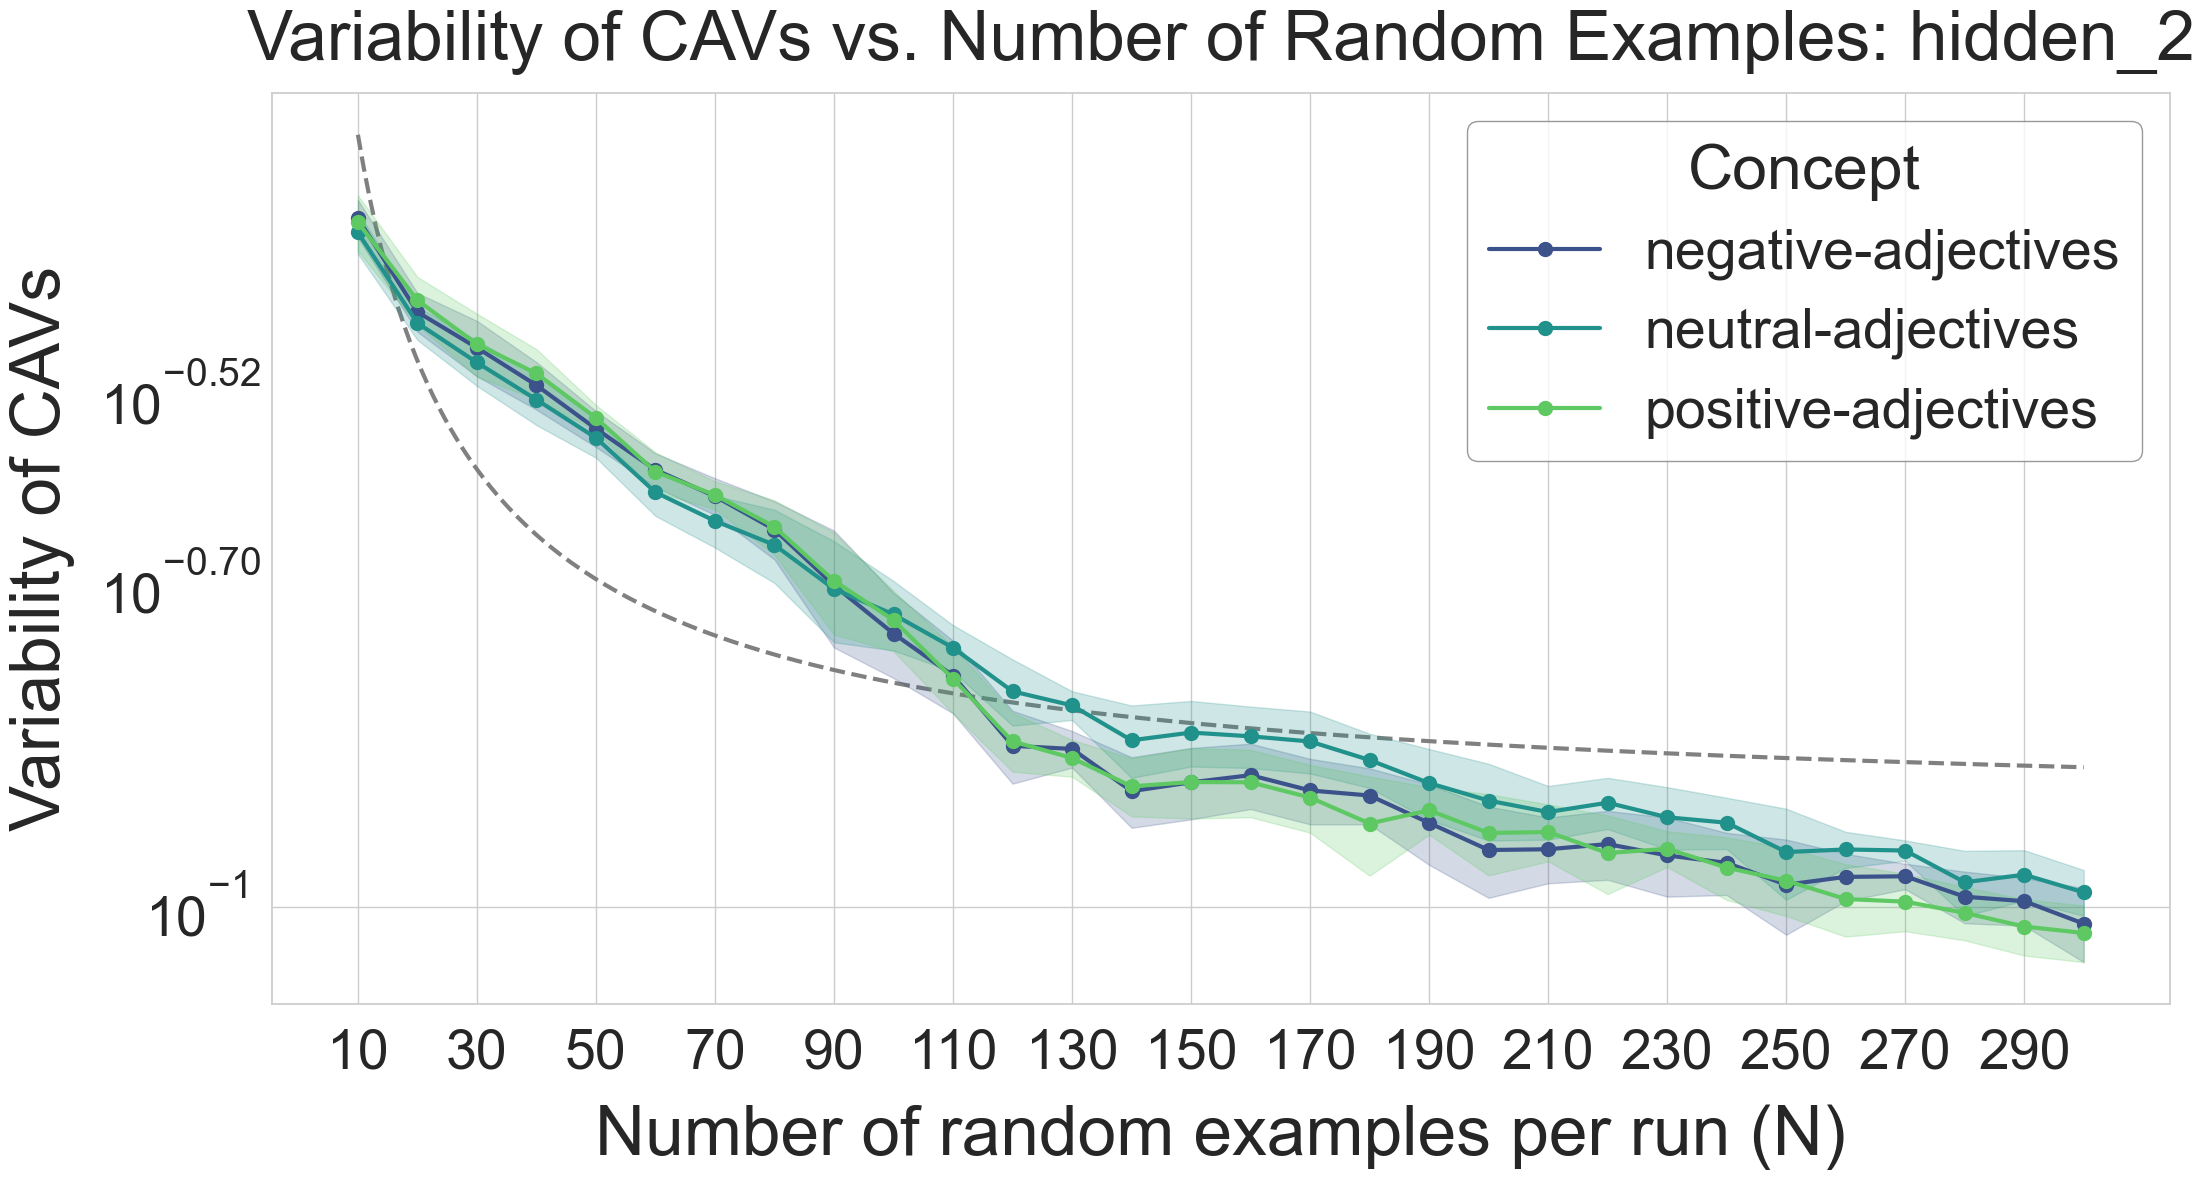

Fit: $ 4.27/N \; + \; 0.0958 $
Plot saved to artifacts/text/distilbert-base-uncased-finetuned-sst-2-english/logistic/plots/cav_vector_variance__distilbert-base-uncased-finetuned-sst-2-english_hidden_4_logistic.pdf


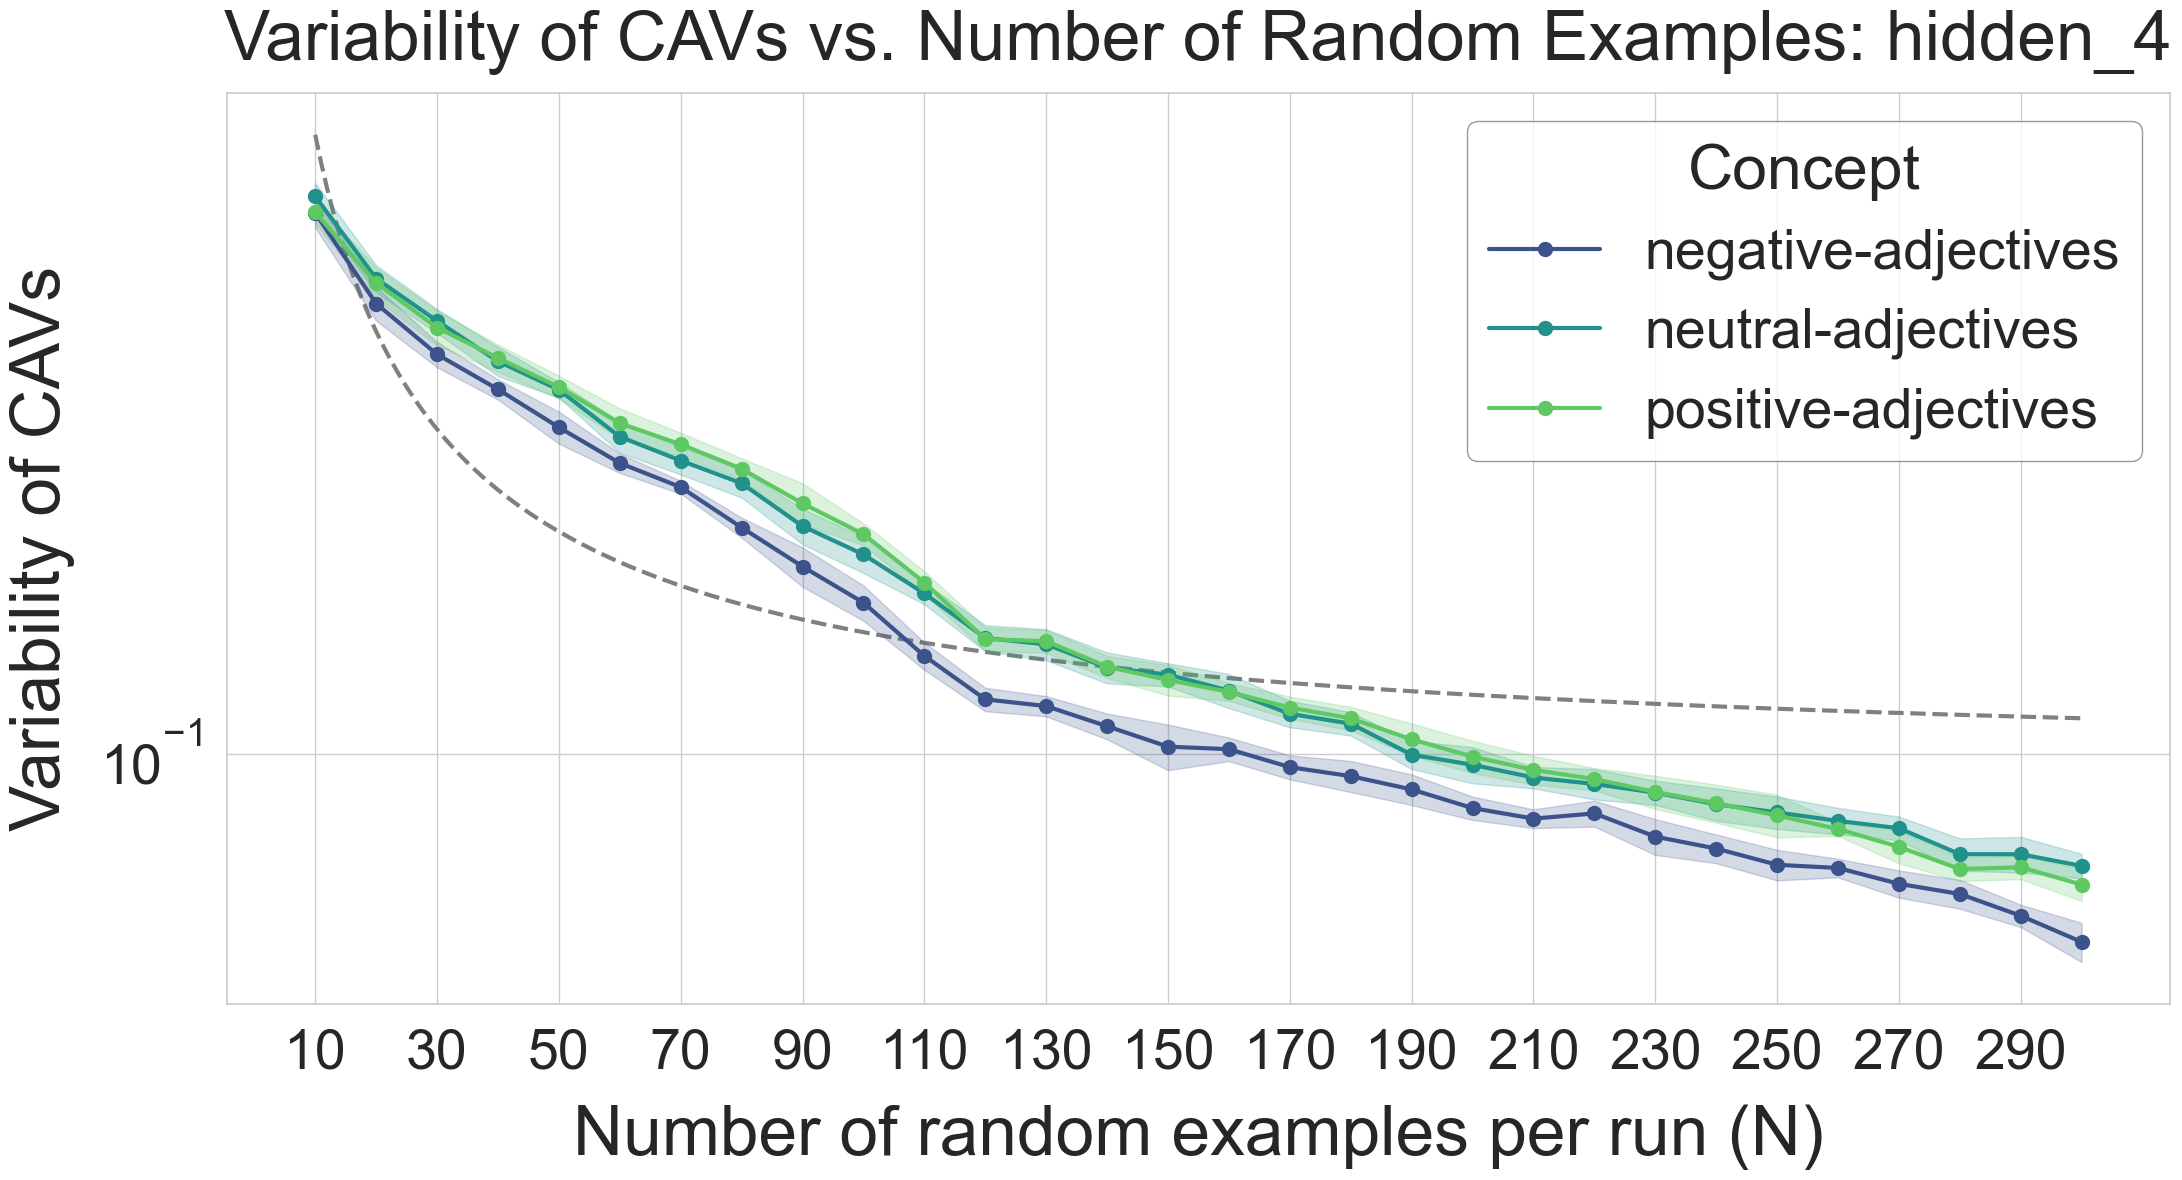

Fit: $ 6.36/N \; + \; 0.141 $
Plot saved to artifacts/text/distilbert-base-uncased-finetuned-sst-2-english/logistic/plots/cav_vector_variance__distilbert-base-uncased-finetuned-sst-2-english_hidden_6_logistic.pdf


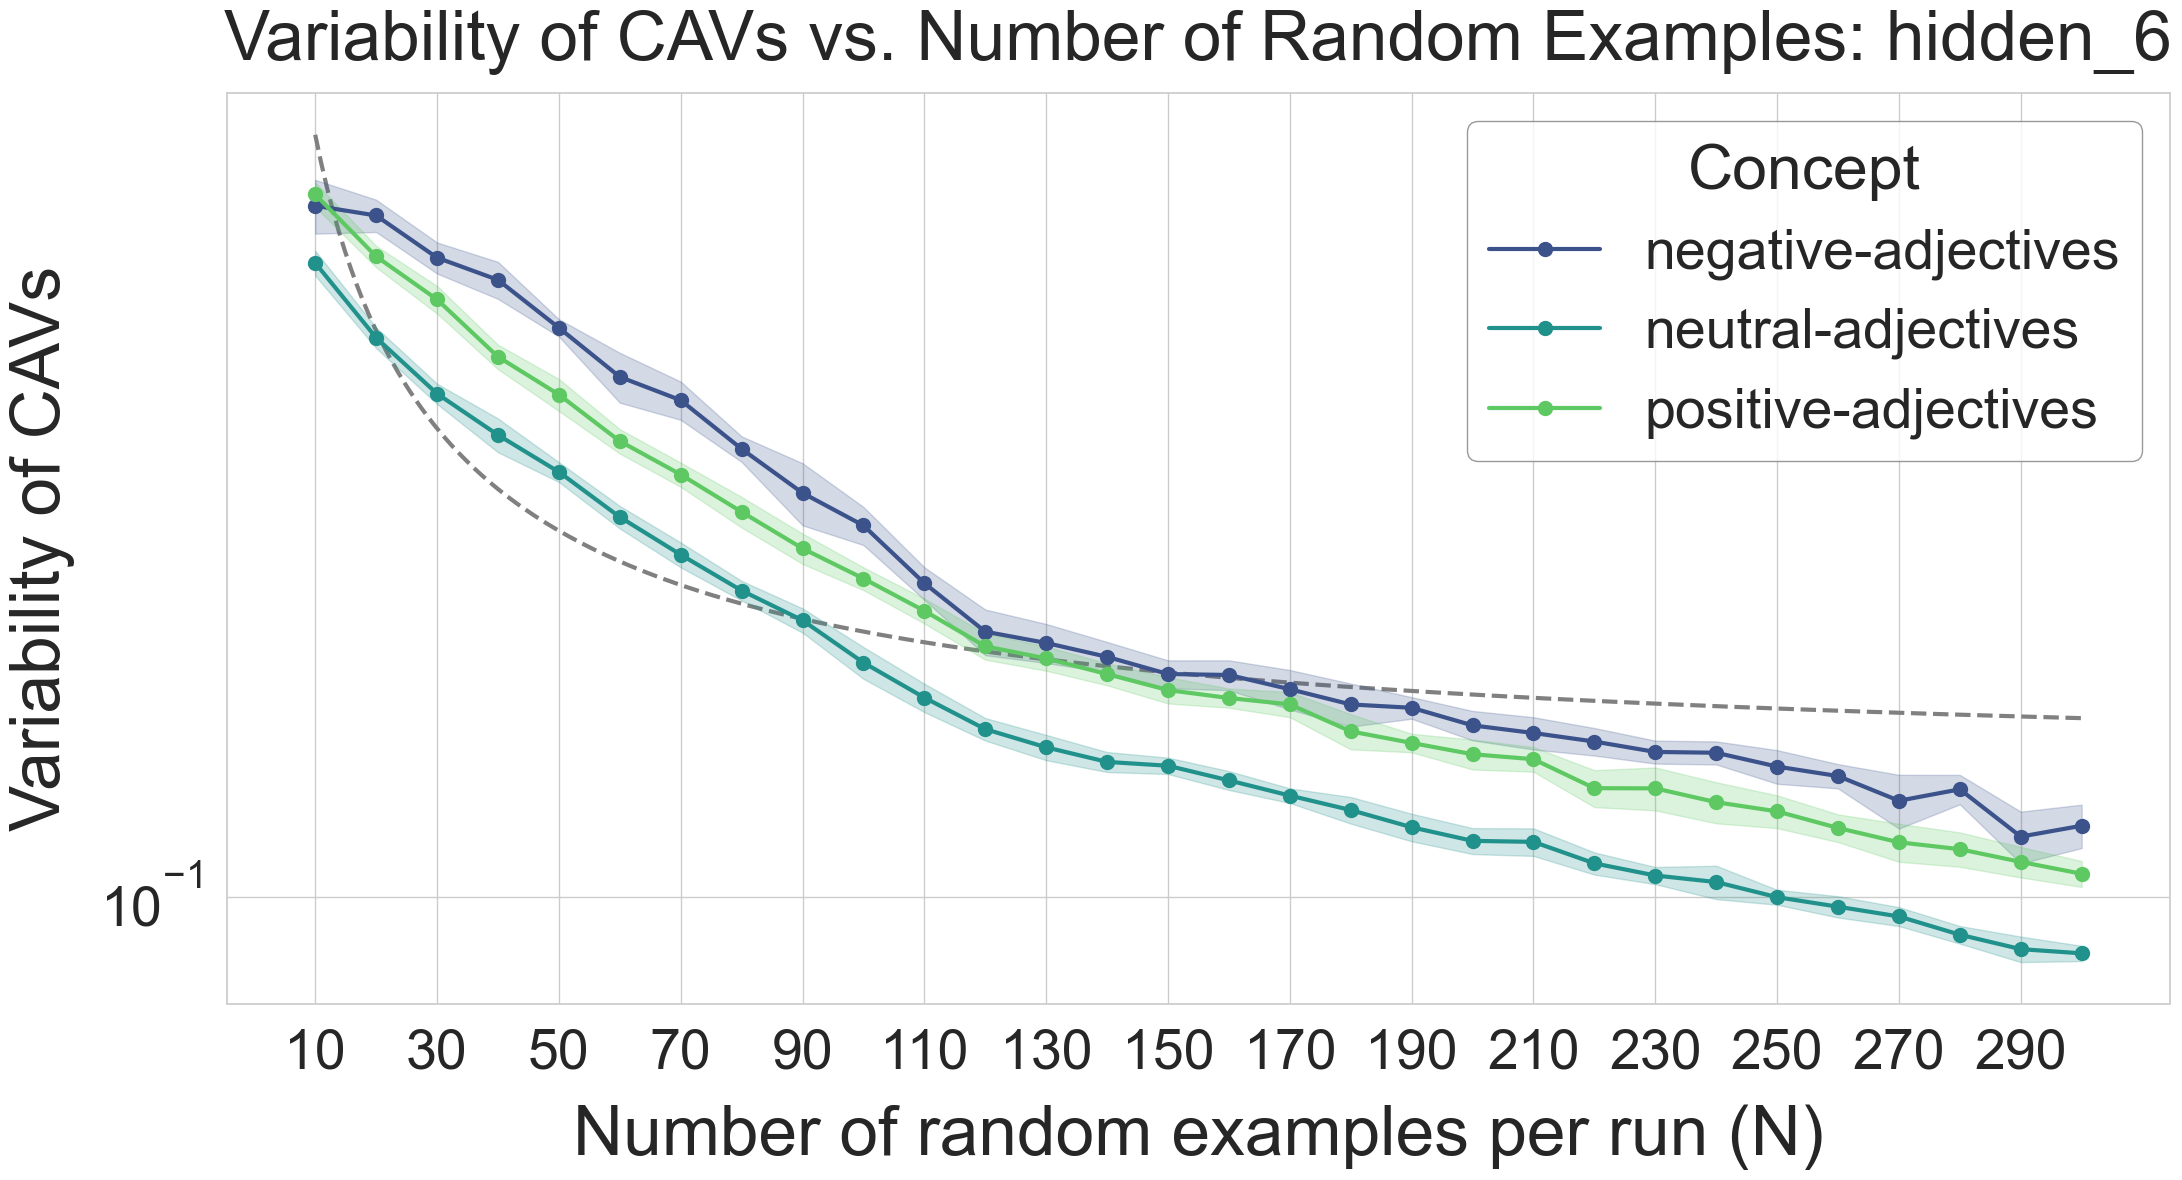

In [11]:

# -----------------------------
# 5) Variability of CAV vectors (trace variance) per layer
# -----------------------------
for layer_name in layer_names:
    df_var = load_cav_vector_variance_data_cached(
        layer=layer_name,
        cav_output_dir=cfg.out_dir,
        concepts_to_load=cfg.dataset.concepts,
        n_values=list(cfg.n_values),
        runs=int(cfg.runs),
        cache_dir=CACHE_DIR,
        cache_key=f"trace_variance__{cfg.dataset.name}_{cfg.method}_{layer_name}",
        load_if_exists=LOAD_IF_EXISTS,
        save=True,
    )
    plot_variance_vs_n(
        df=df_var,
        layer=layer_name,
        title=f"Variability of CAVs vs. Number of Random Examples: {layer_name}",
        ylabel="Variability of CAVs",
        save_path=os.path.join(cfg.out_dir, "plots", f"cav_vector_variance__{MODEL}_{layer_name}_{METHOD}.pdf"),
        fit_thresholds=[0],
        cache_dir=CACHE_DIR,
        cache_key=f"cav_vector_variance_{MODEL}_{layer_name}_{METHOD}",
        load_if_exists=LOAD_IF_EXISTS,
        save_bundle=True,
    )


Fit: $ 5.38\times 10^{-6}/N \; + \; 1.27\times 10^{-7} $
Plot saved to artifacts/text/distilbert-base-uncased-finetuned-sst-2-english/logistic/plots/sensitivity_variance_distilbert-base-uncased-finetuned-sst-2-english_hidden_2_logistic.pdf


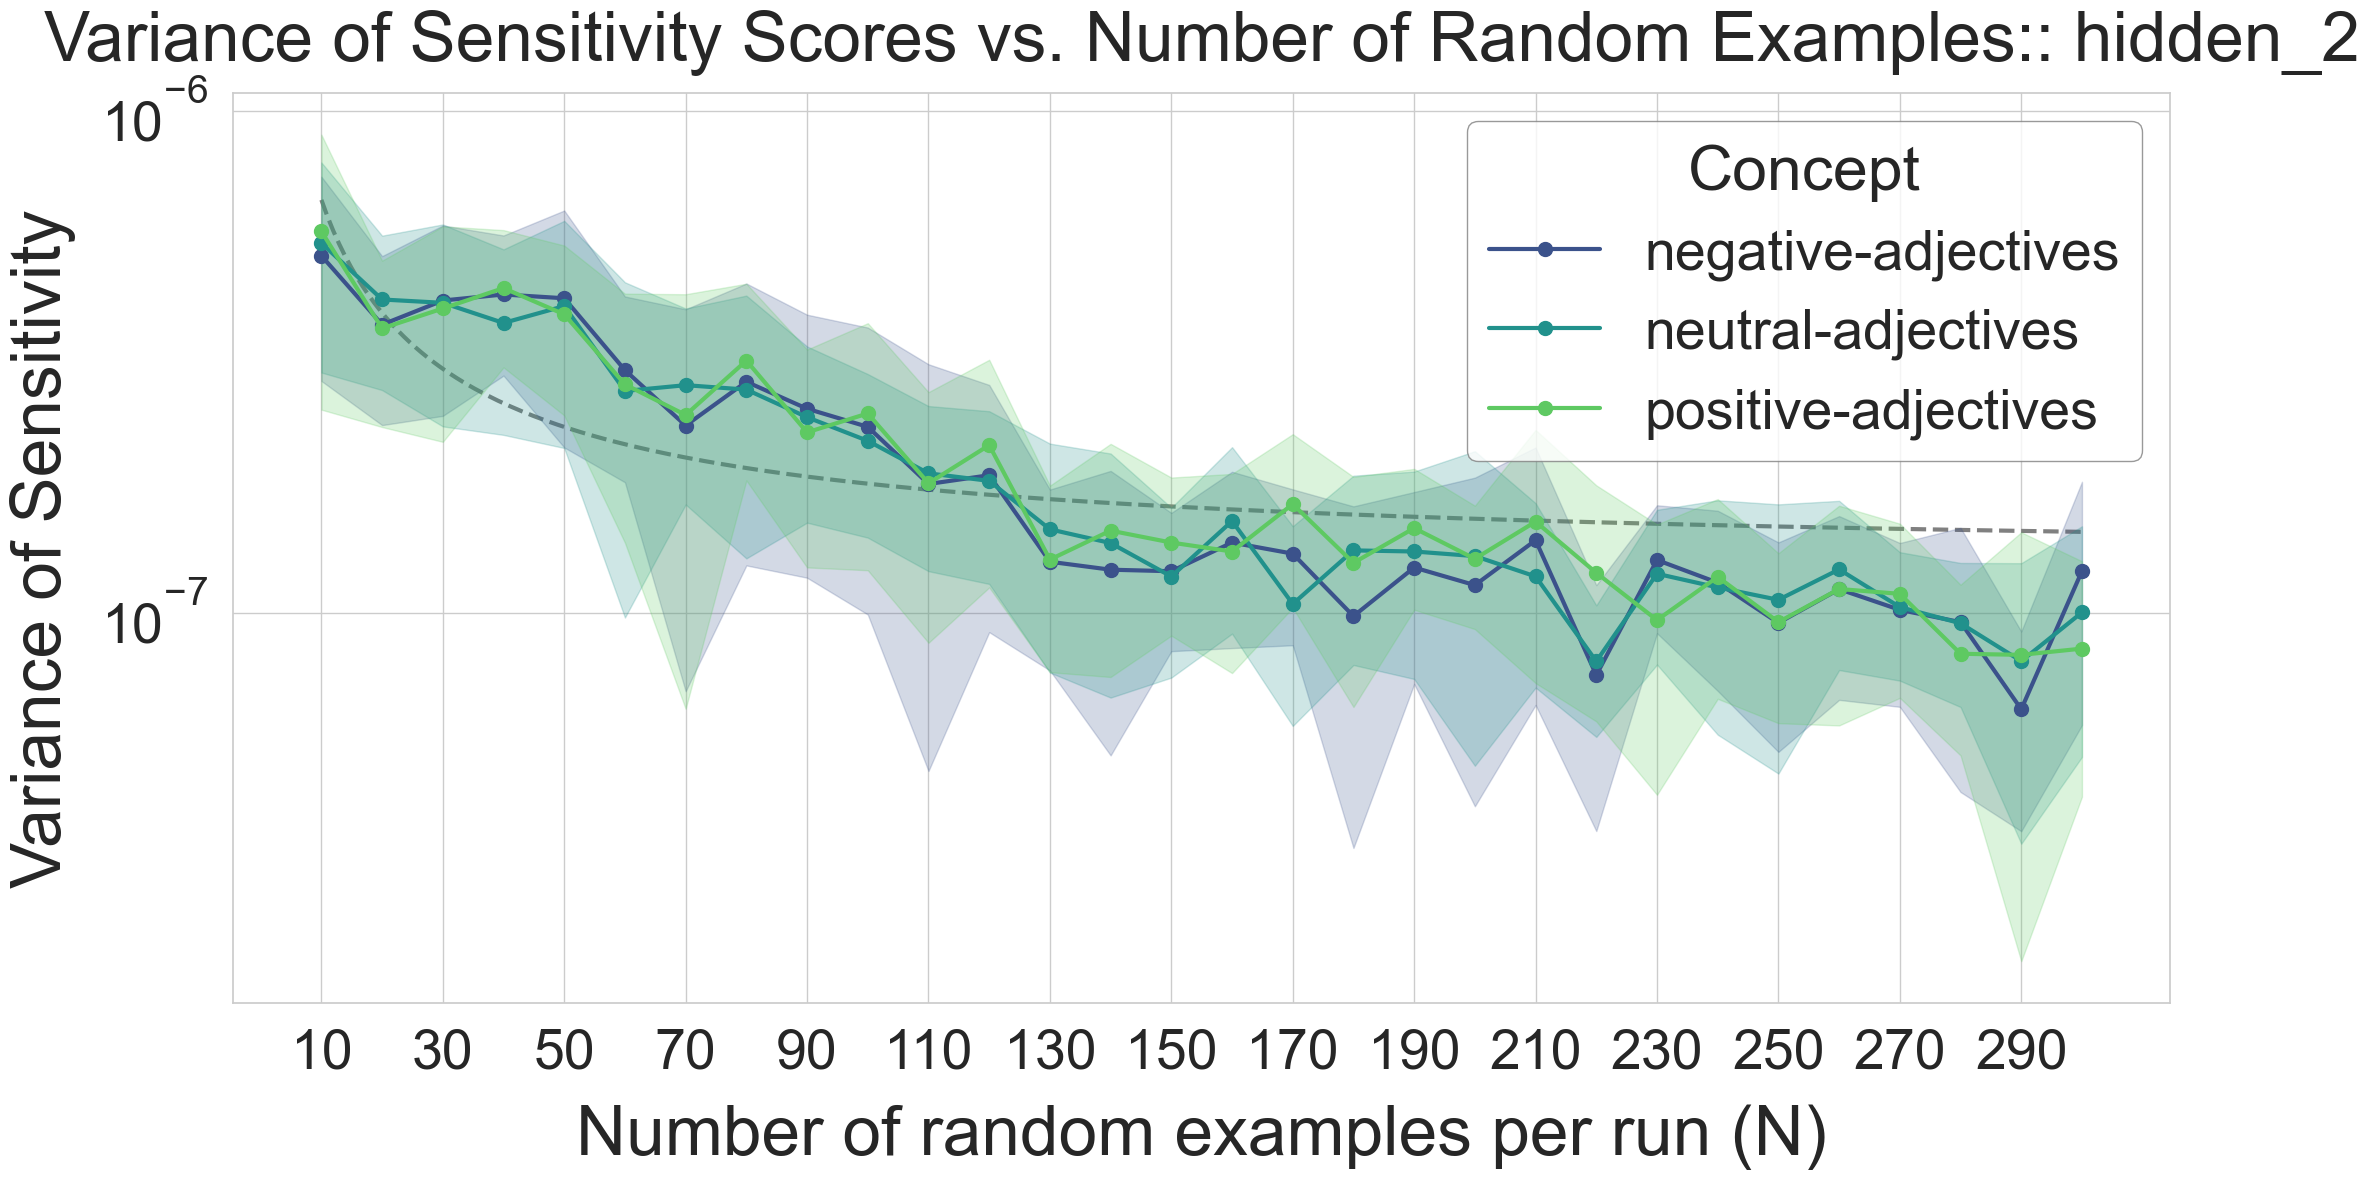

Fit: $ 5.63\times 10^{-6}/N \; + \; 7.51\times 10^{-8} $
Plot saved to artifacts/text/distilbert-base-uncased-finetuned-sst-2-english/logistic/plots/sensitivity_variance_distilbert-base-uncased-finetuned-sst-2-english_hidden_4_logistic.pdf


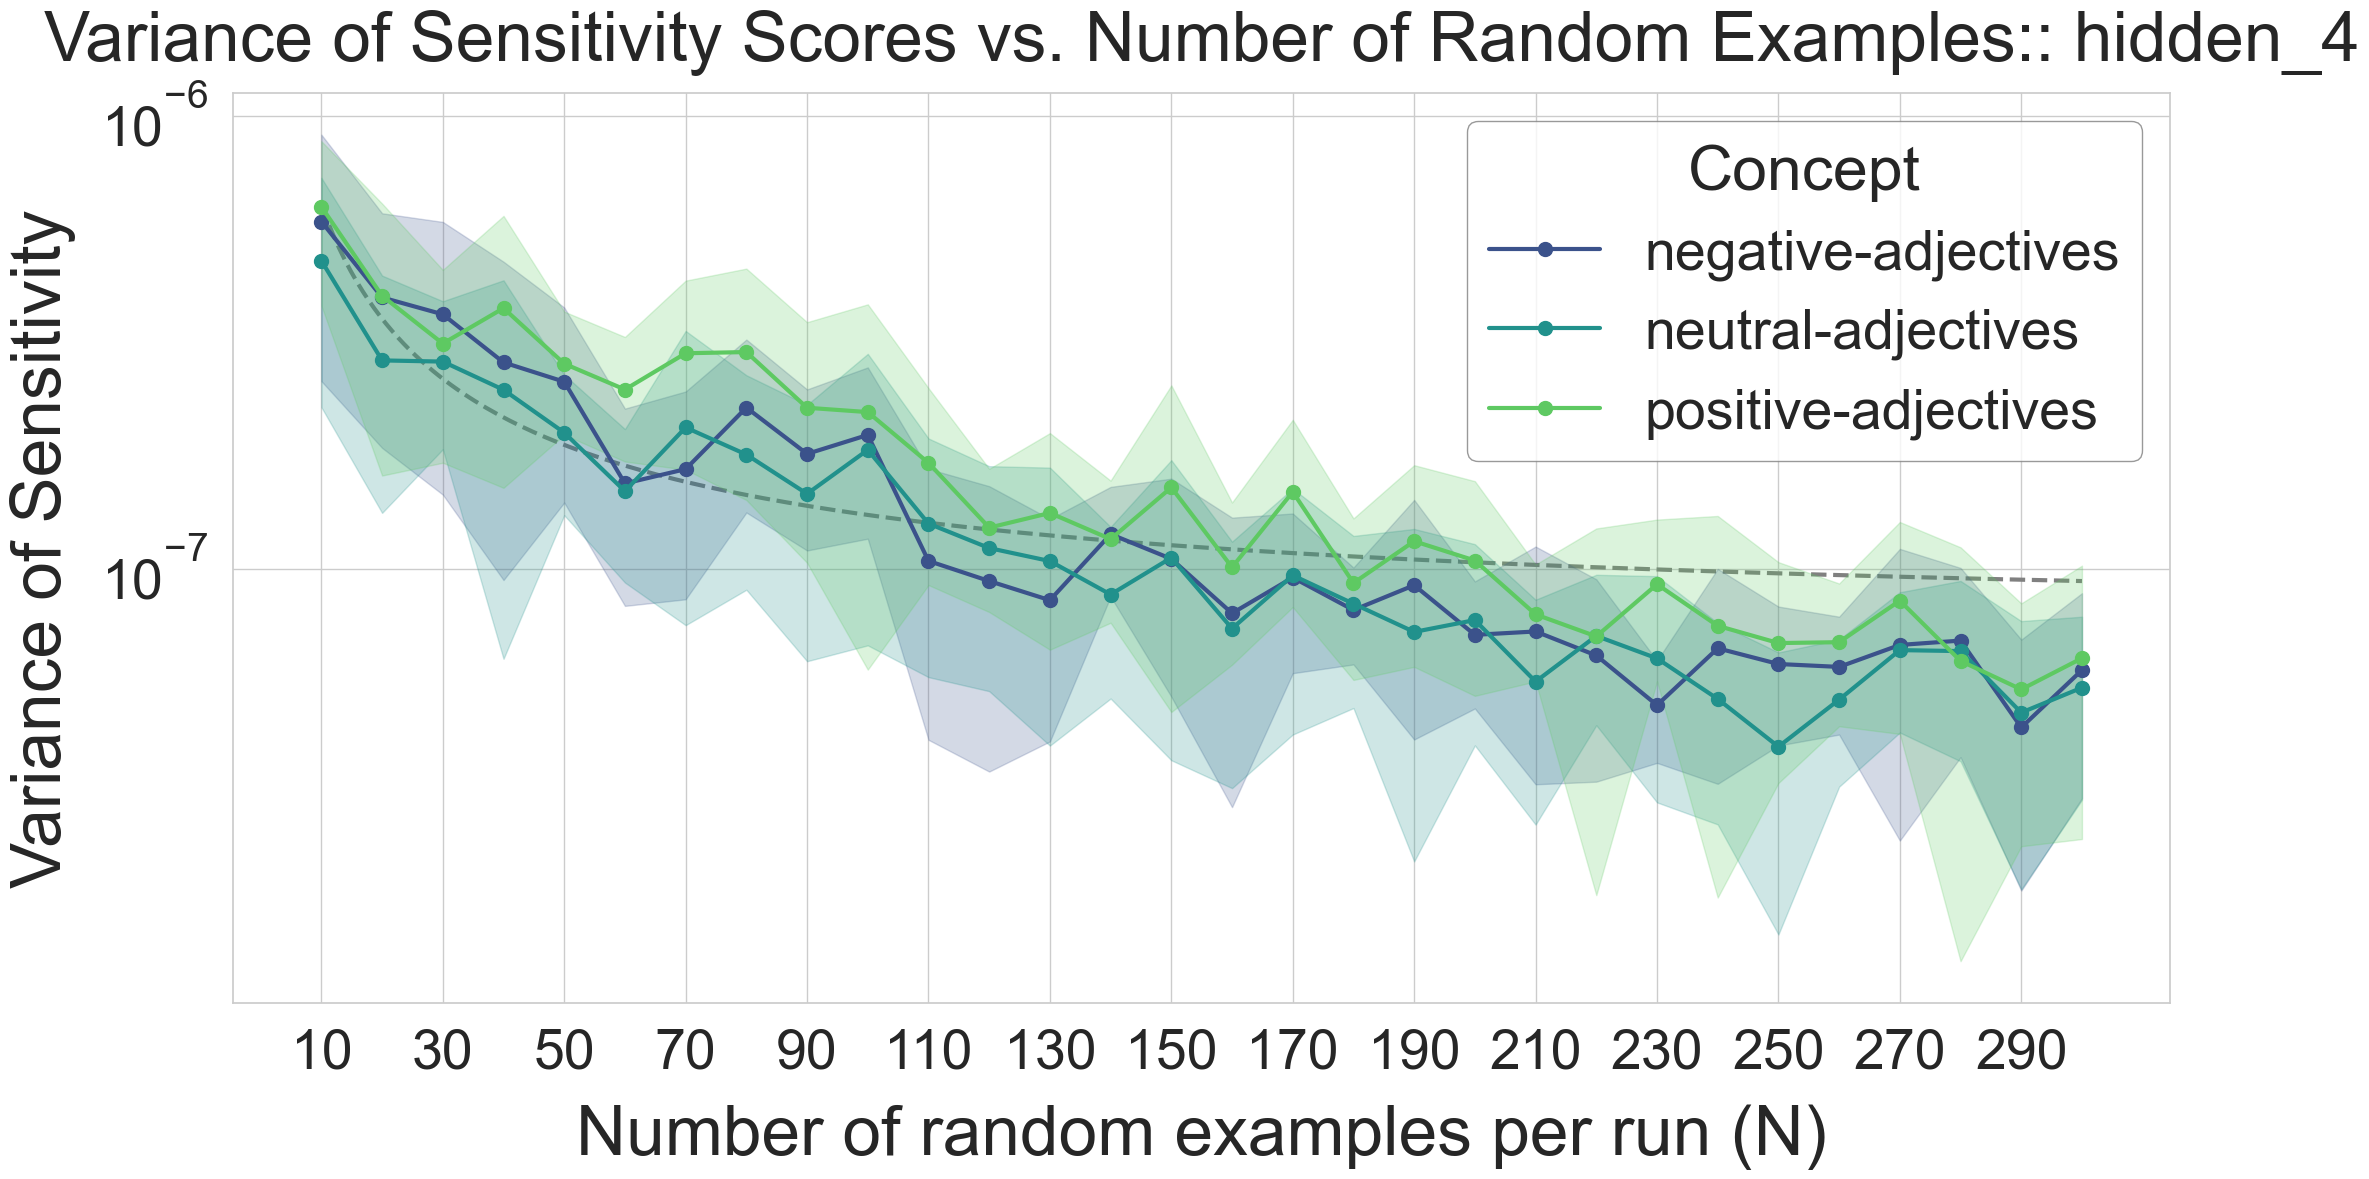

Fit: $ 8.72\times 10^{-5}/N \; + \; 6.05\times 10^{-7} $
Plot saved to artifacts/text/distilbert-base-uncased-finetuned-sst-2-english/logistic/plots/sensitivity_variance_distilbert-base-uncased-finetuned-sst-2-english_hidden_6_logistic.pdf


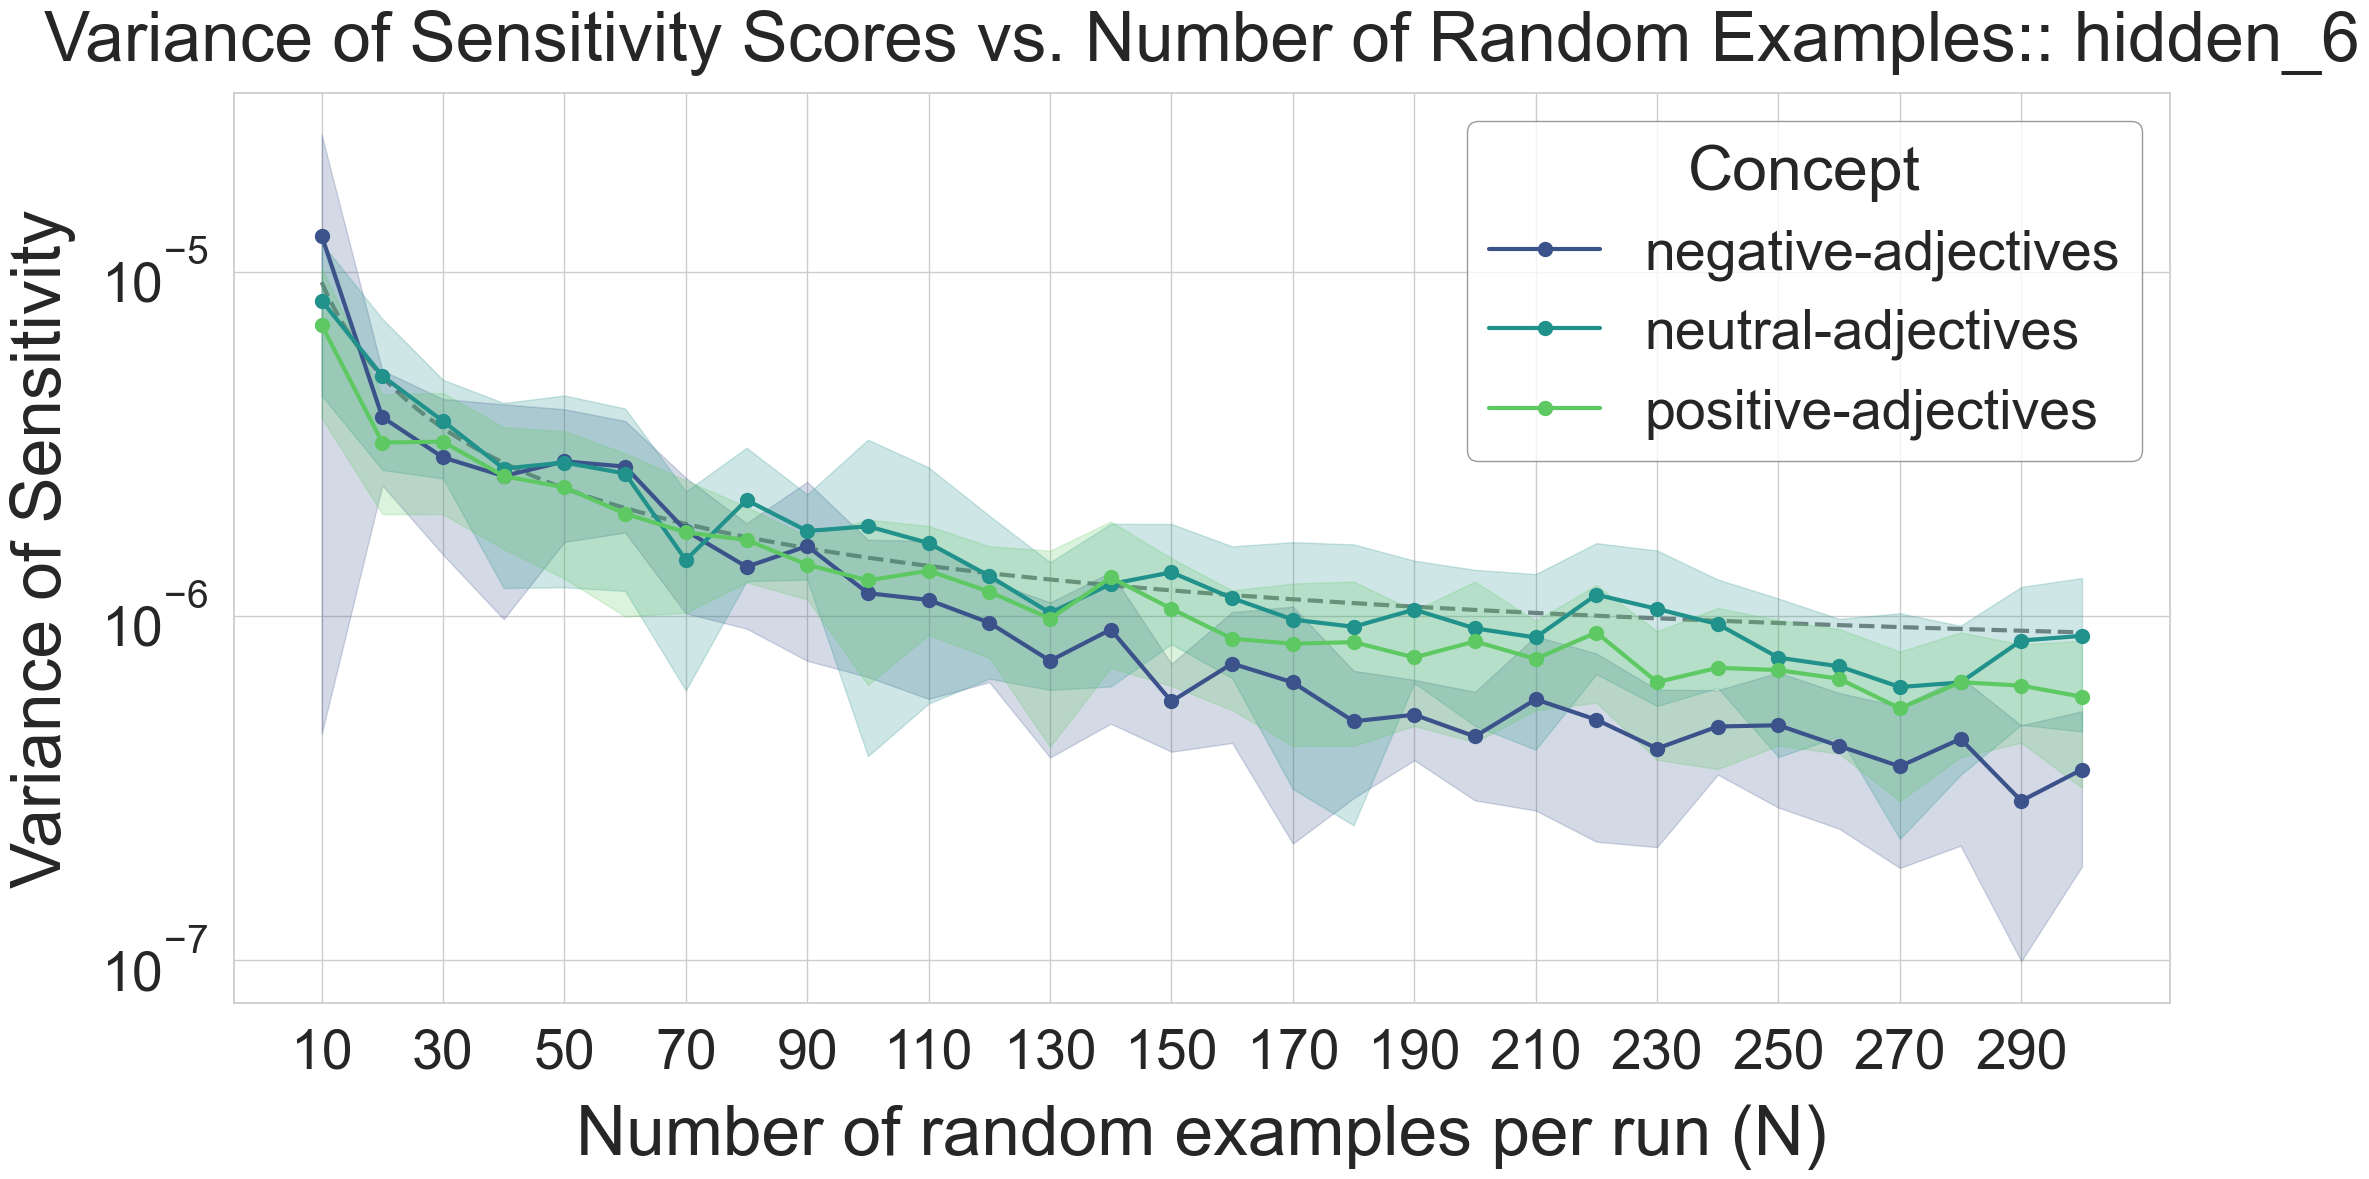

In [12]:

# -----------------------------
# 6) Sensitivity score variance (single gradient vector per layer)
# -----------------------------
from tcavlab.models.text import tokenize_texts
from tcavlab.activations import get_text_gradients

single_grad_by_layer = {}
if class_texts:
    enc_one = tokenize_texts([class_texts[0]], tokenizer, max_length=128, device=DEVICE)
    for layer_index, layer_name in zip(layer_indices, layer_names):
        G = get_text_gradients(model, enc_one, layer_index, cfg.dataset.target_class_index)
        if G is not None:
            single_grad_by_layer[layer_name] = G[0]
        else:
            print("No gradient for", layer_name)

for layer_name in layer_names:
    g = single_grad_by_layer.get(layer_name)
    if g is None: 
        continue
    df_sens = load_sensitivity_score_variance_data_cached(
        layer=layer_name,
        gradient_vector=g,
        cav_output_dir=cfg.out_dir,
        concepts_to_load=cfg.dataset.concepts,
        n_values=list(cfg.n_values),
        runs=int(cfg.runs),
        cache_dir=CACHE_DIR,
        cache_key=f"sens_score_var__{cfg.dataset.name}_{cfg.method}_{layer_name}",
        load_if_exists=LOAD_IF_EXISTS,
        save=True,
    )
    plot_variance_vs_n(
        df=df_sens,
        layer=layer_name,
        title=f"Variance of Sensitivity Scores vs. Number of Random Examples:: {layer_name}",
        ylabel="Variance of Sensitivity",
        save_path=os.path.join(cfg.out_dir, "plots", f"sensitivity_variance_{MODEL}_{layer_name}_{METHOD}.pdf"),
        fit_thresholds=[0],
        cache_dir=CACHE_DIR,
        cache_key=f"sens_var_plot__{cfg.dataset.name}_{cfg.method}_{layer_name}",
        load_if_exists=LOAD_IF_EXISTS,
        save_bundle=True,
    )


Fit: $ 0.295/N \; + \; 0.00654 $
Plot saved to artifacts/text/distilbert-base-uncased-finetuned-sst-2-english/logistic/plots/tcav_score_variance_distilbert-base-uncased-finetuned-sst-2-english_hidden_2_logistic.pdf


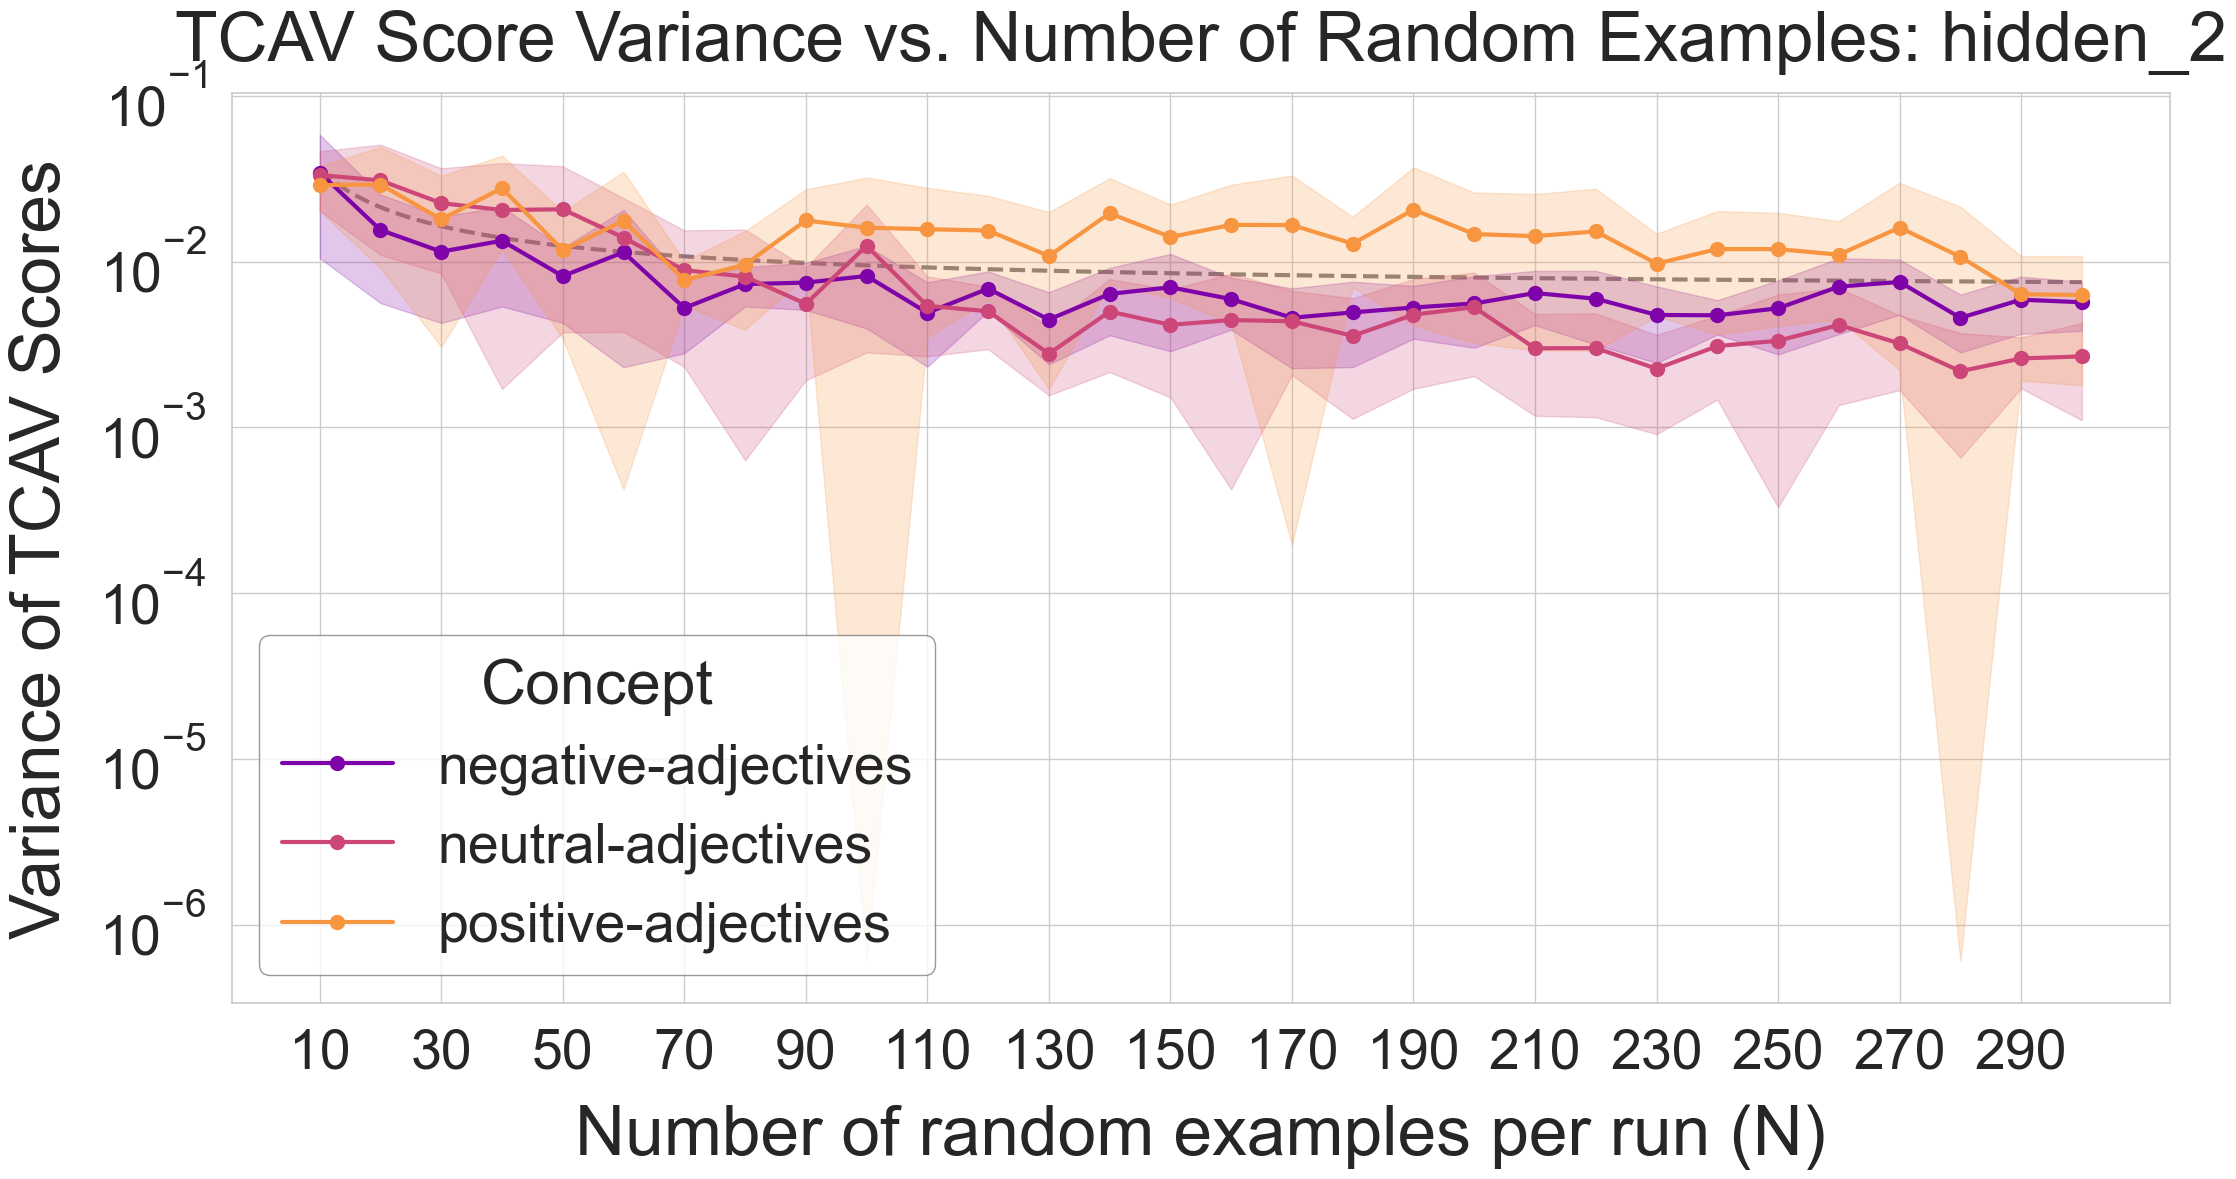

Fit: $ 0.329/N \; + \; 0.0226 $
Plot saved to artifacts/text/distilbert-base-uncased-finetuned-sst-2-english/logistic/plots/tcav_score_variance_distilbert-base-uncased-finetuned-sst-2-english_hidden_4_logistic.pdf


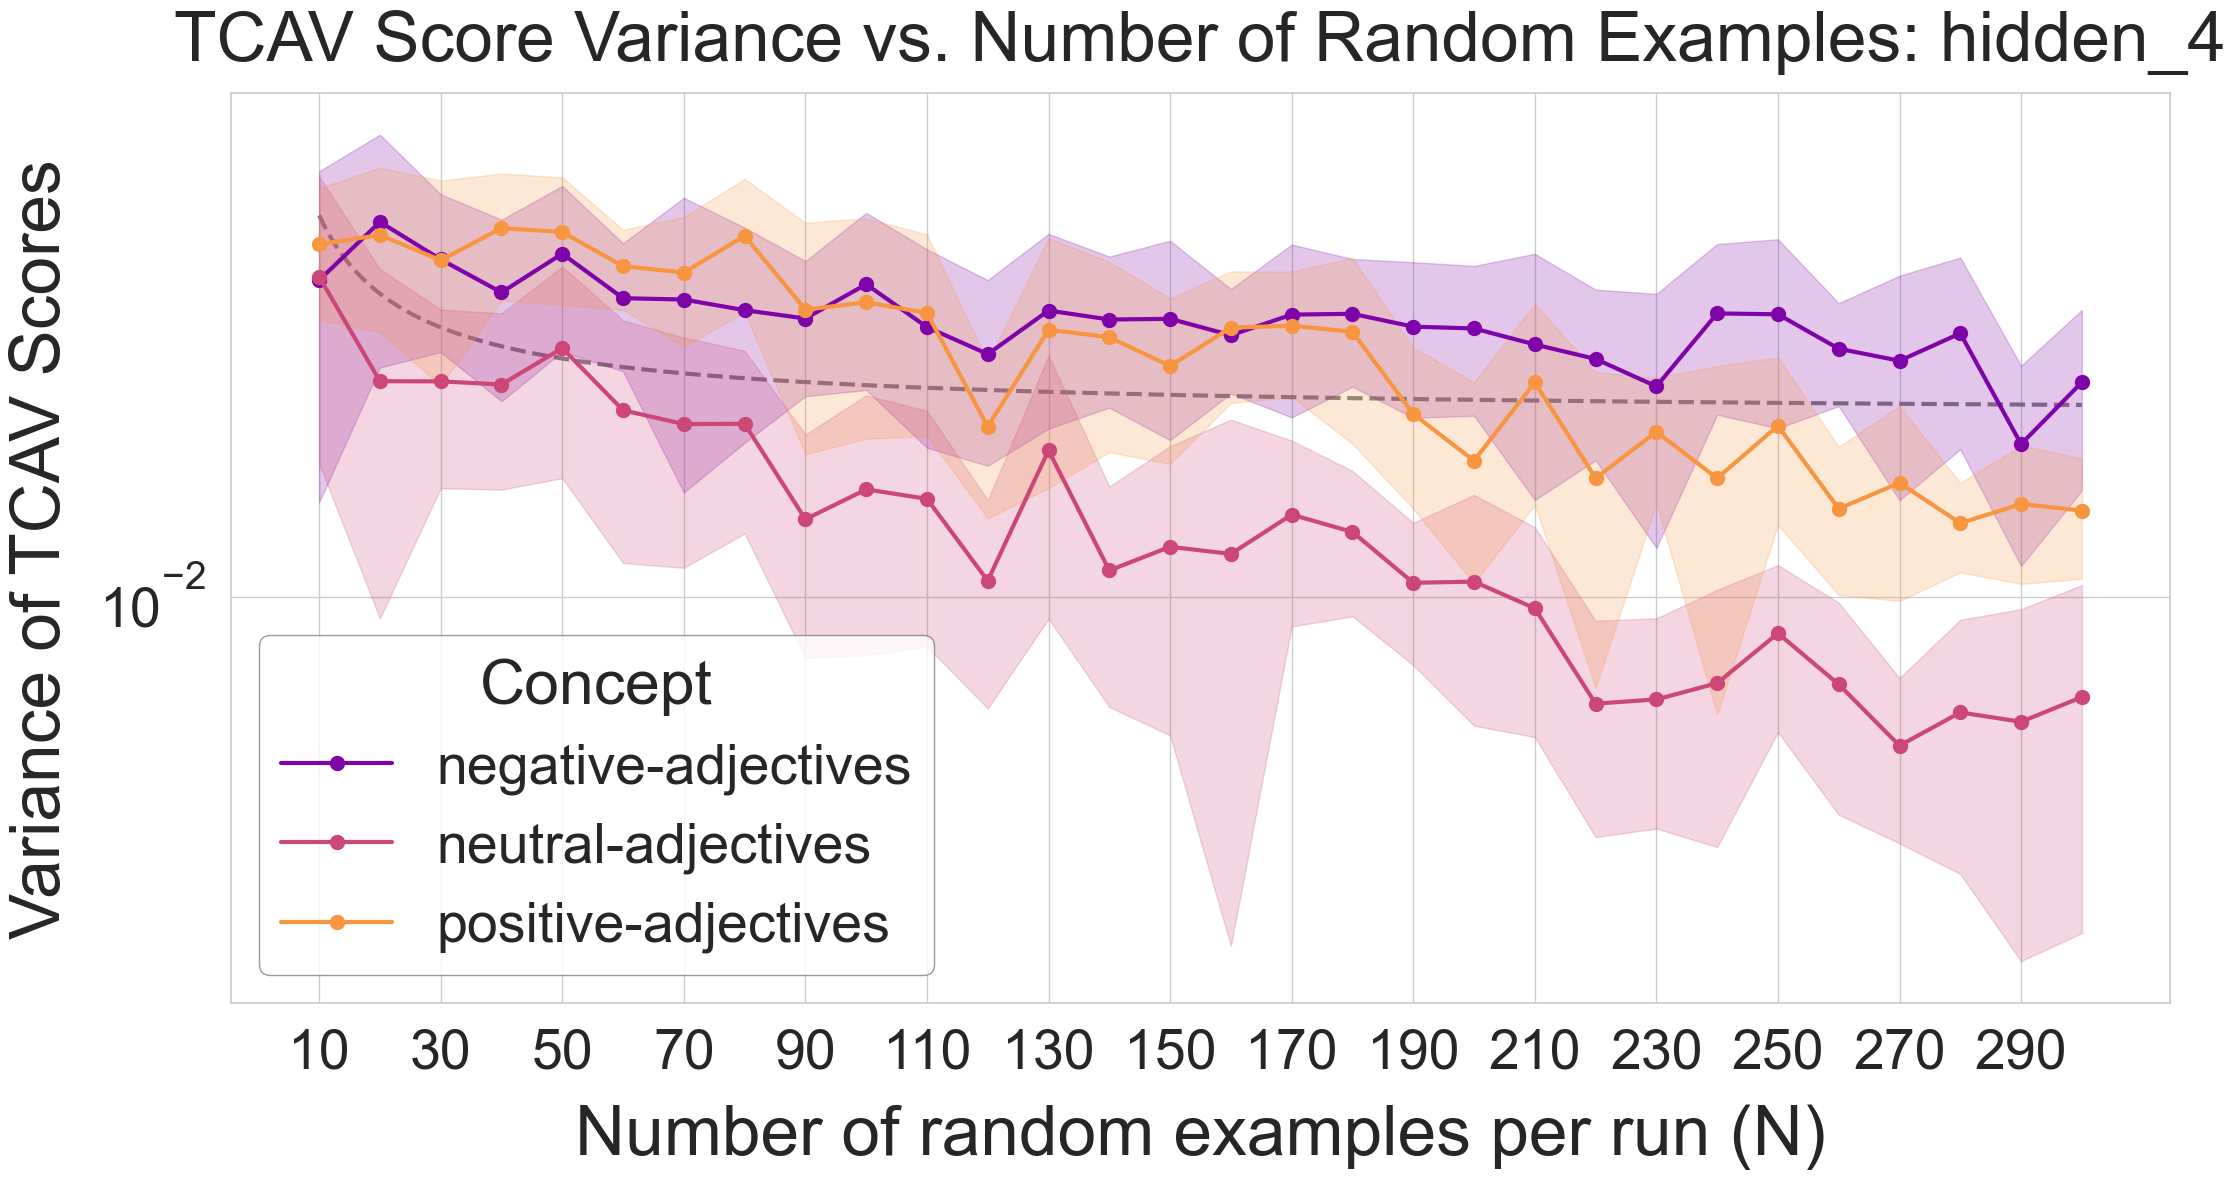

Fit: $ 0.84/N \; + \; 0.105 $
Plot saved to artifacts/text/distilbert-base-uncased-finetuned-sst-2-english/logistic/plots/tcav_score_variance_distilbert-base-uncased-finetuned-sst-2-english_hidden_6_logistic.pdf


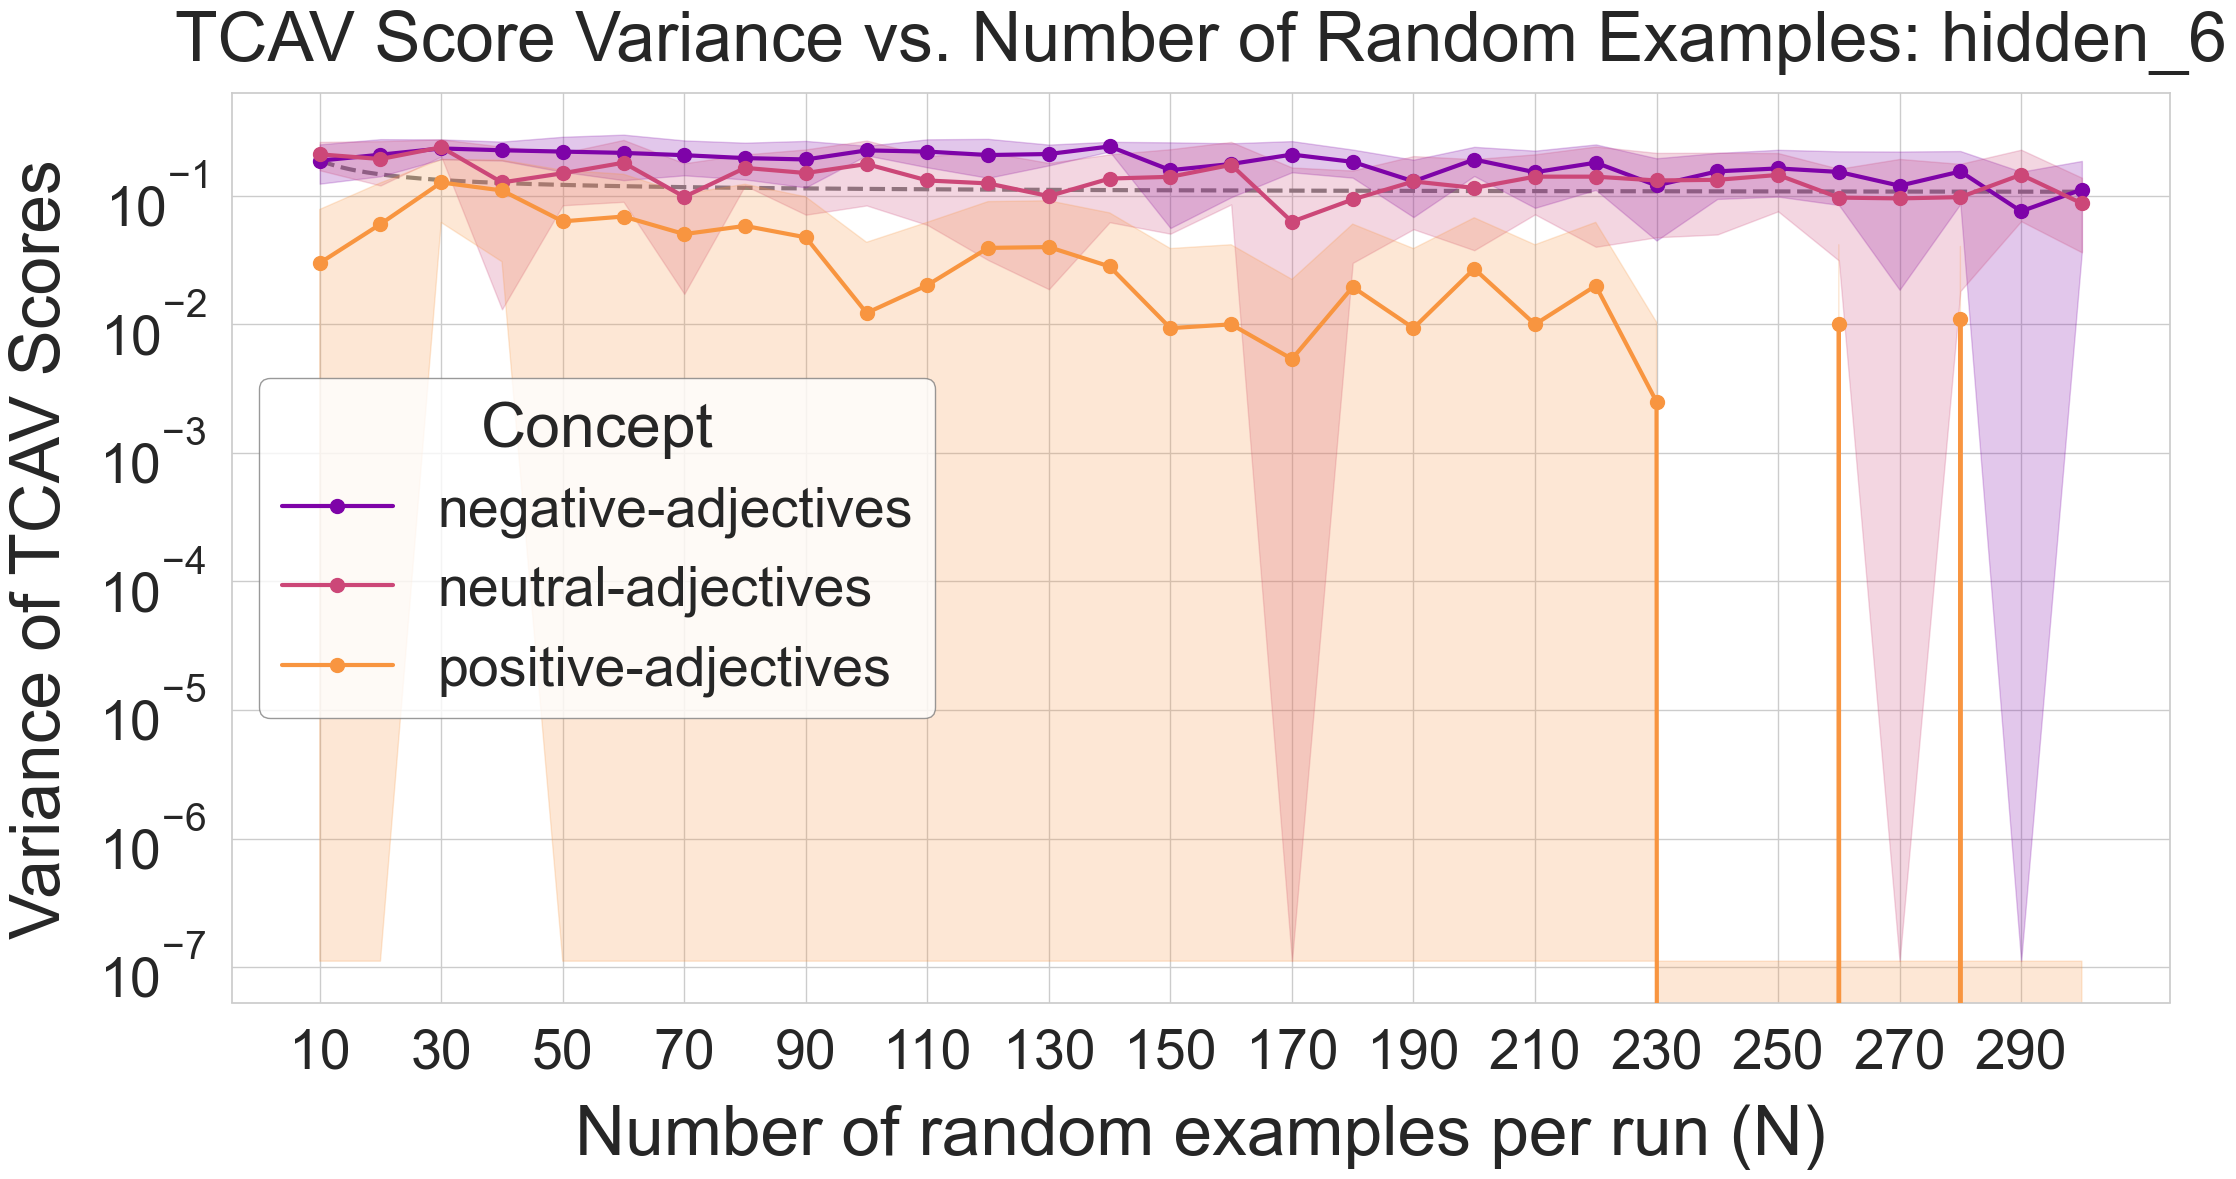

All text analyses complete.


In [13]:

# -----------------------------
# 7) TCAV score variance per layer (across concepts)
# -----------------------------
BATCH=16
grads_by_layer = {}
for layer_index, layer_name in zip(layer_indices, layer_names):
    grads = []
    for i in range(0, len(class_texts), BATCH):
        enc = tokenize_texts(class_texts[i:i+BATCH], tokenizer, max_length=128, device=DEVICE)
        G = get_text_gradients(model, enc, layer_index, cfg.dataset.target_class_index)
        if G is not None:
            grads.append(G)
    if grads:
        import numpy as np
        grads_by_layer[layer_name] = np.vstack(grads)

for layer_name in layer_names:
    if layer_name not in grads_by_layer: 
        continue
    df_tcav = calculate_tcav_score_variance_cached(
        layers=[layer_name],
        concepts_to_load=cfg.dataset.concepts,
        n_values=list(cfg.n_values),
        runs=int(cfg.runs),
        gradients_per_layer=grads_by_layer,
        cav_output_dir=cfg.out_dir,
        cache_dir=CACHE_DIR,
        cache_key=f"tcav_score_var__{cfg.dataset.name}_{cfg.method}_{layer_name}",
        load_if_exists=LOAD_IF_EXISTS,
        save=True,
    )
    df_layer = df_tcav[df_tcav["layer"] == layer_name].copy()
    plot_tcav_score_variance(
        df=df_layer,
        layer_name=layer_name,
        palette="plasma",
        save_path=os.path.join(cfg.out_dir, "plots", f"tcav_score_variance_{MODEL}_{layer_name}_{METHOD}.pdf"),
        cache_dir=CACHE_DIR,
        cache_key=f"tcav_score_var_plot__{cfg.dataset.name}_{cfg.method}_{layer_name}",
        load_if_exists=LOAD_IF_EXISTS,
        save_bundle=True,
    )
print("All text analyses complete.")


Layer: hidden_2 — Concept: positive-adjectives
Assumption HOLDS for 'male' concept. Plotting distribution...


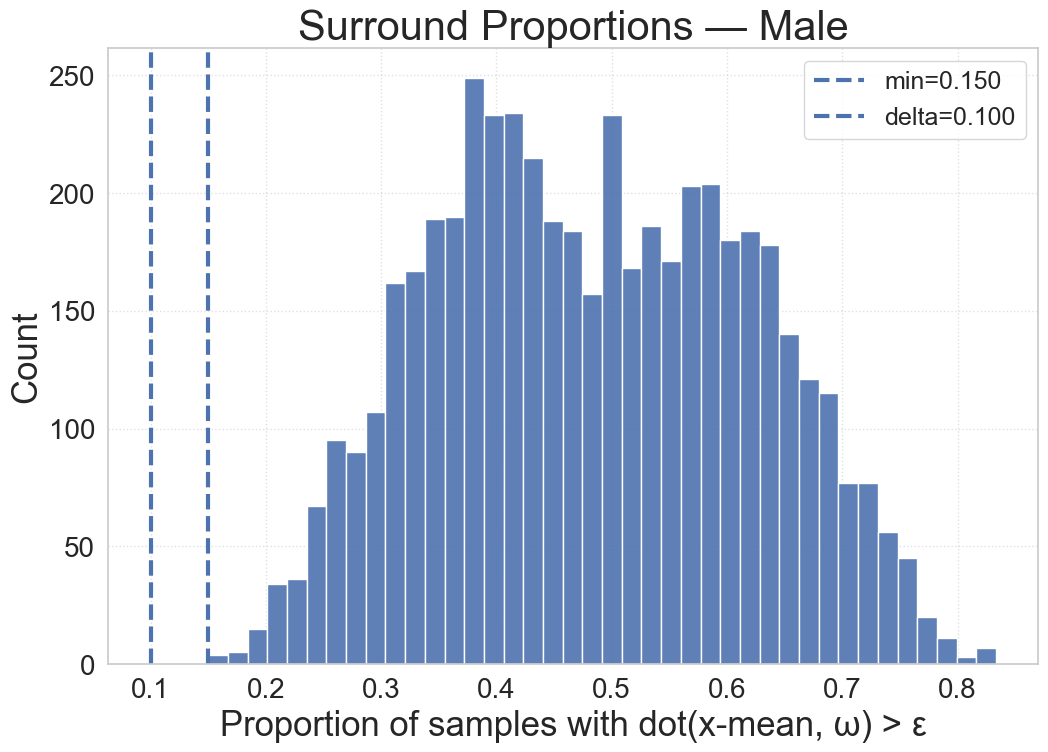

Generating PCA projection plot with larger fonts...


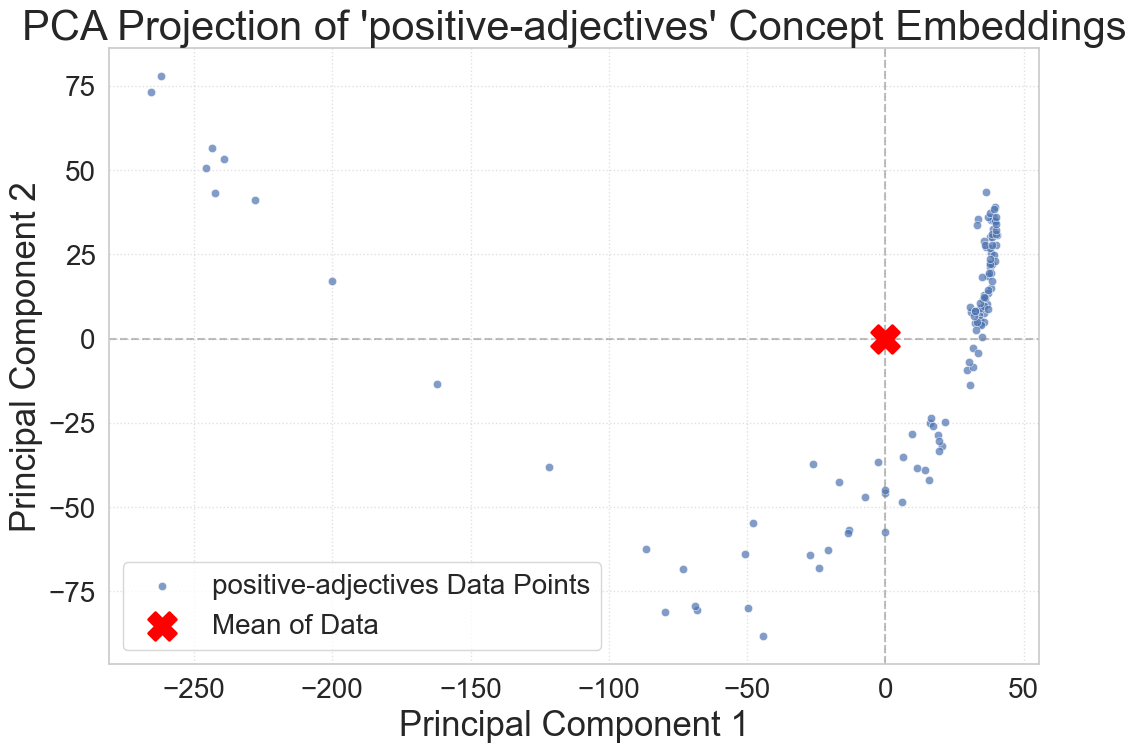

Layer: hidden_2 — Concept: negative-adjectives
Assumption HOLDS for 'male' concept. Plotting distribution...


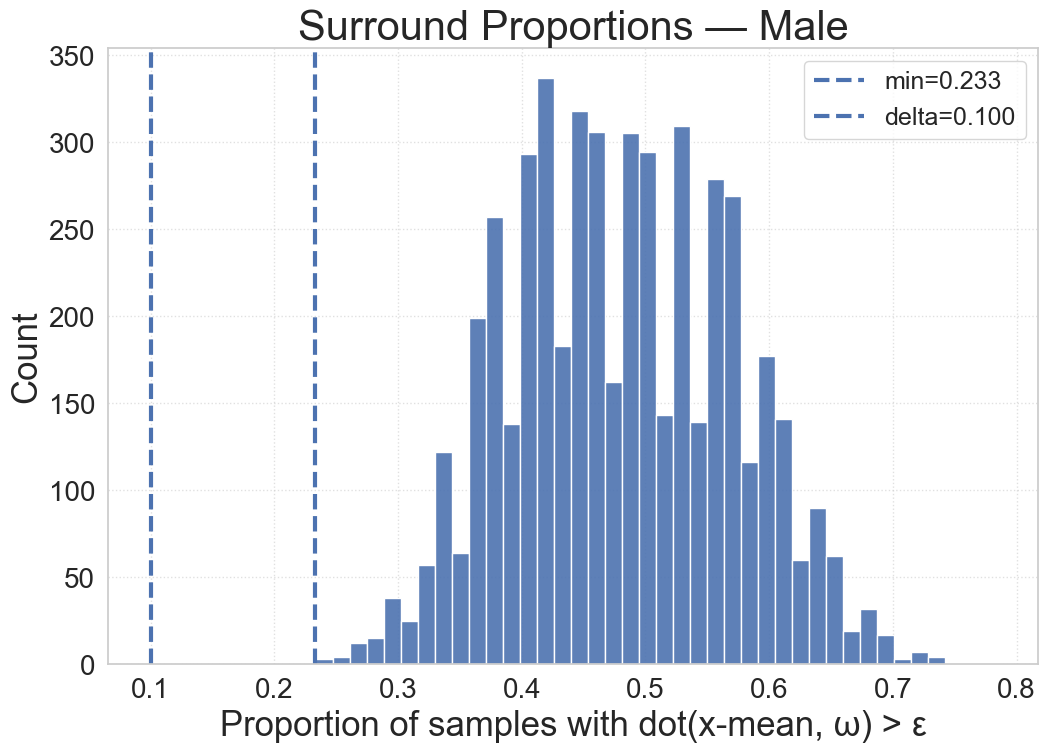

Generating PCA projection plot with larger fonts...


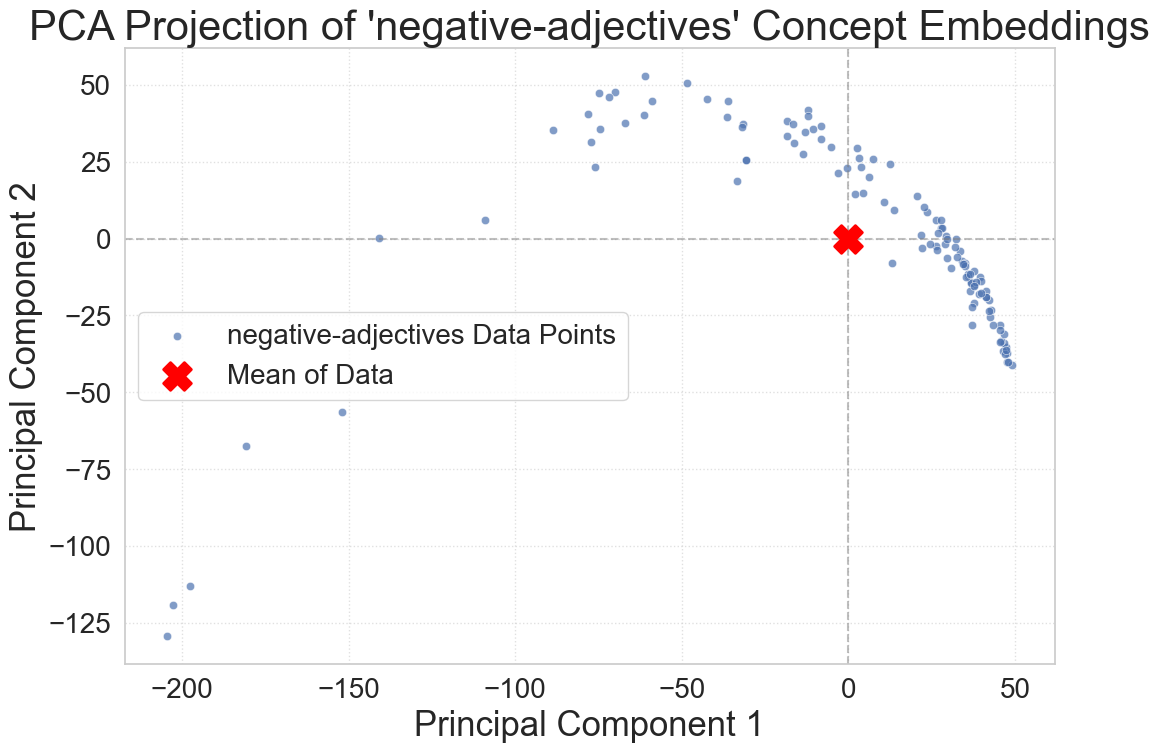

Layer: hidden_2 — Concept: neutral-adjectives
Assumption HOLDS for 'male' concept. Plotting distribution...


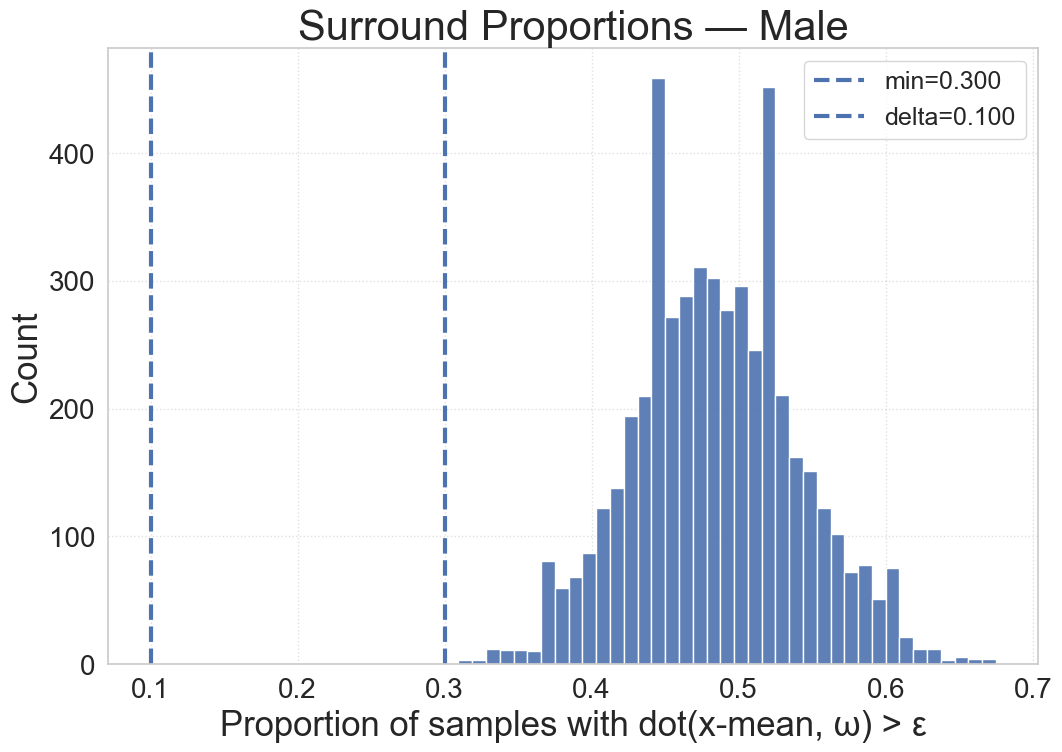

Generating PCA projection plot with larger fonts...


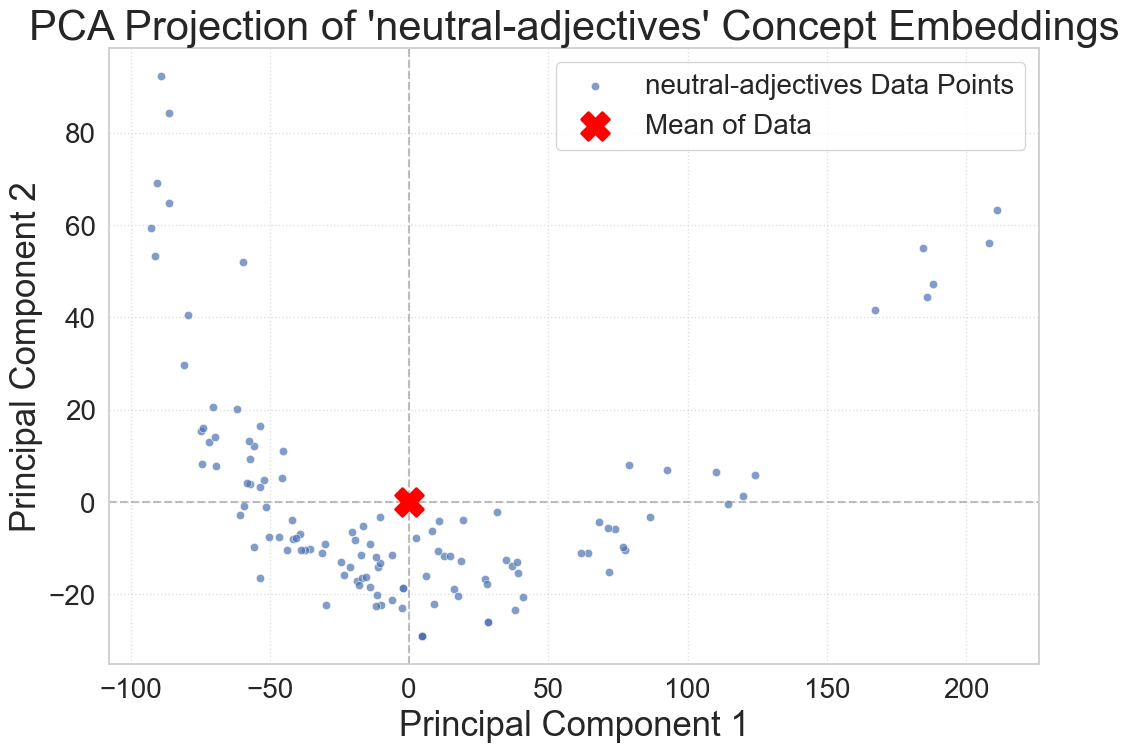

Layer: hidden_4 — Concept: positive-adjectives
Assumption HOLDS for 'male' concept. Plotting distribution...


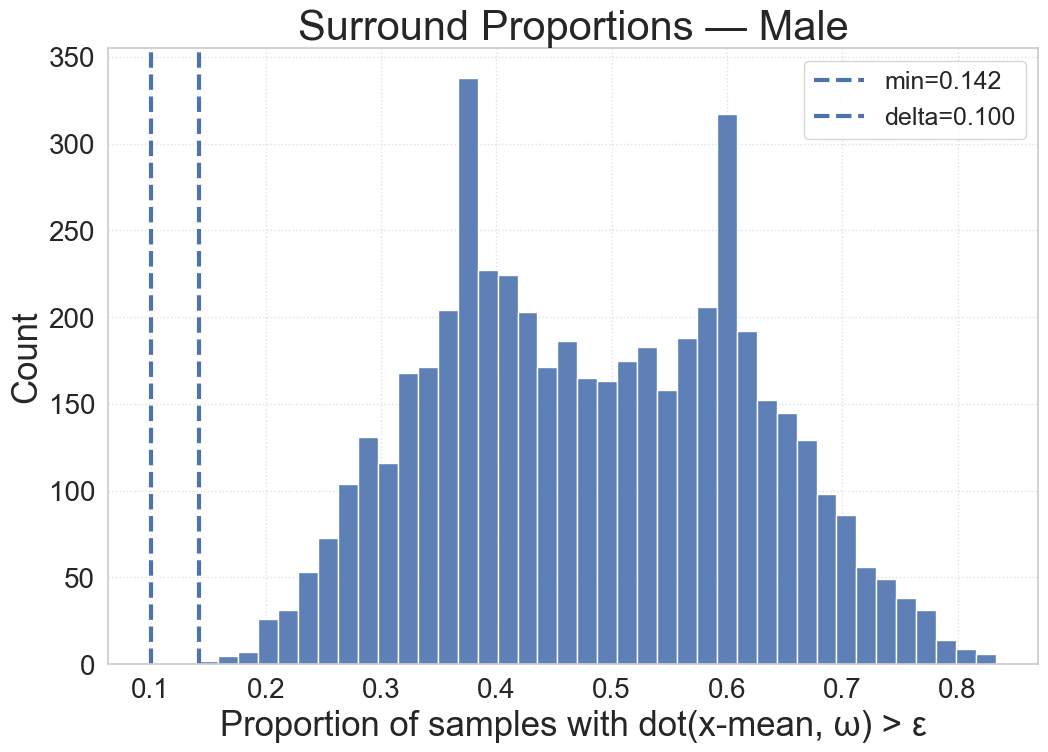

Generating PCA projection plot with larger fonts...


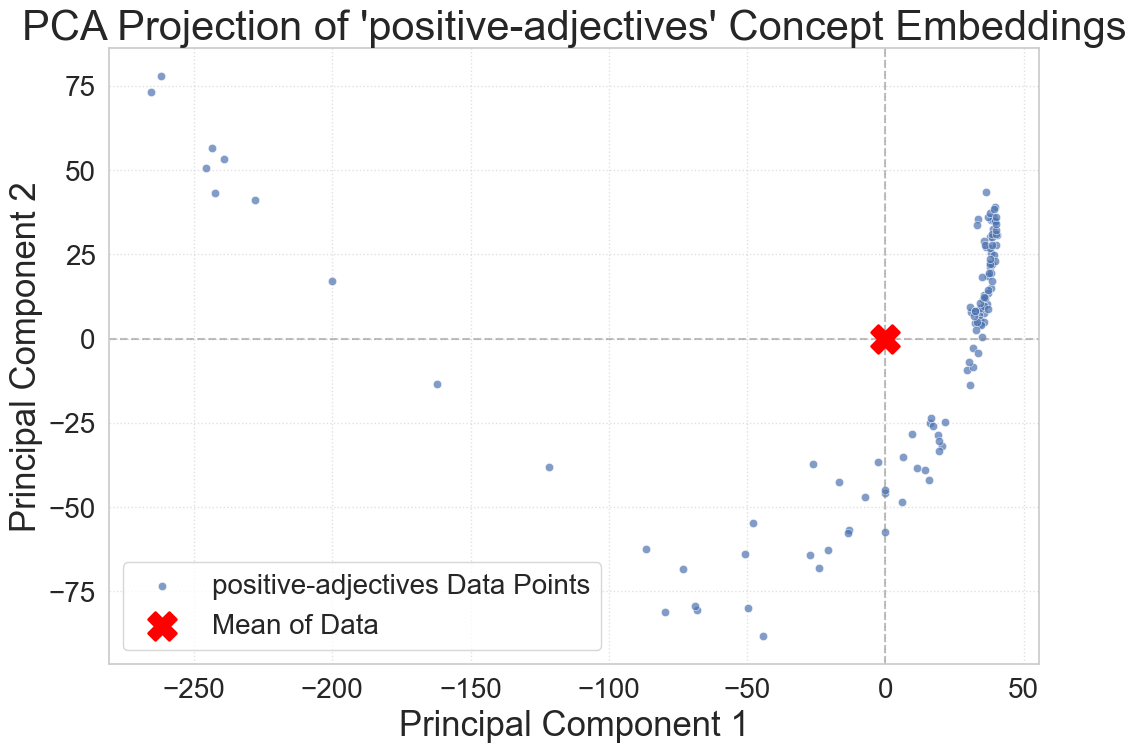

Layer: hidden_4 — Concept: negative-adjectives
Assumption HOLDS for 'male' concept. Plotting distribution...


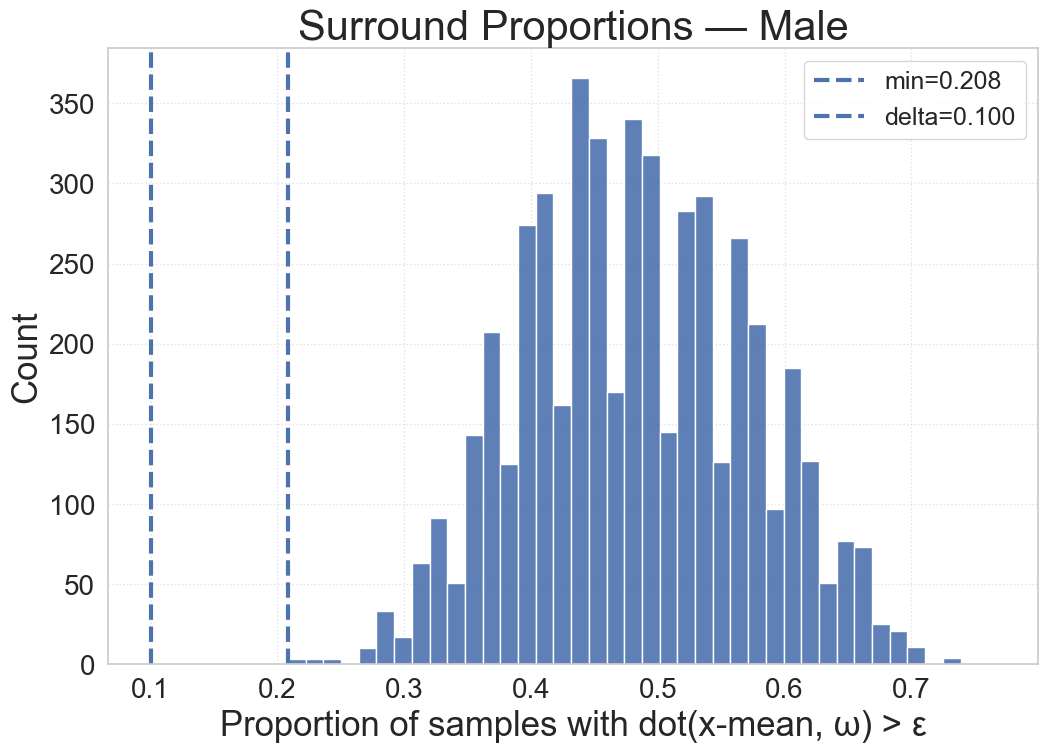

Generating PCA projection plot with larger fonts...


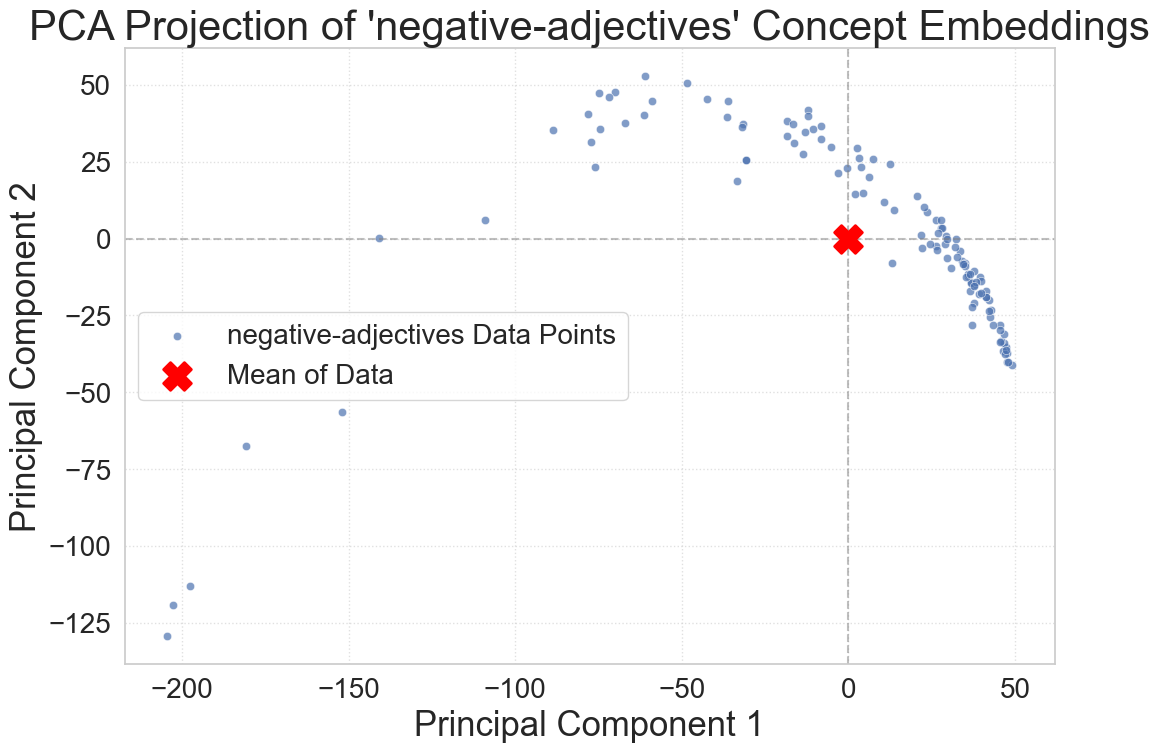

Layer: hidden_4 — Concept: neutral-adjectives
Assumption HOLDS for 'male' concept. Plotting distribution...


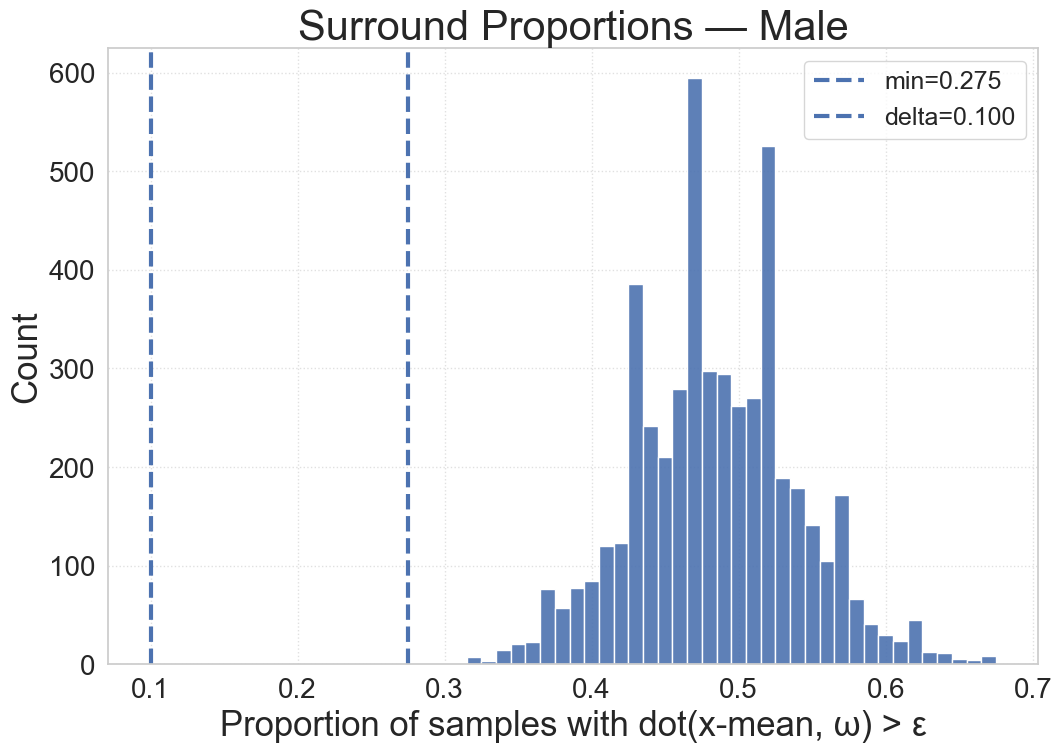

Generating PCA projection plot with larger fonts...


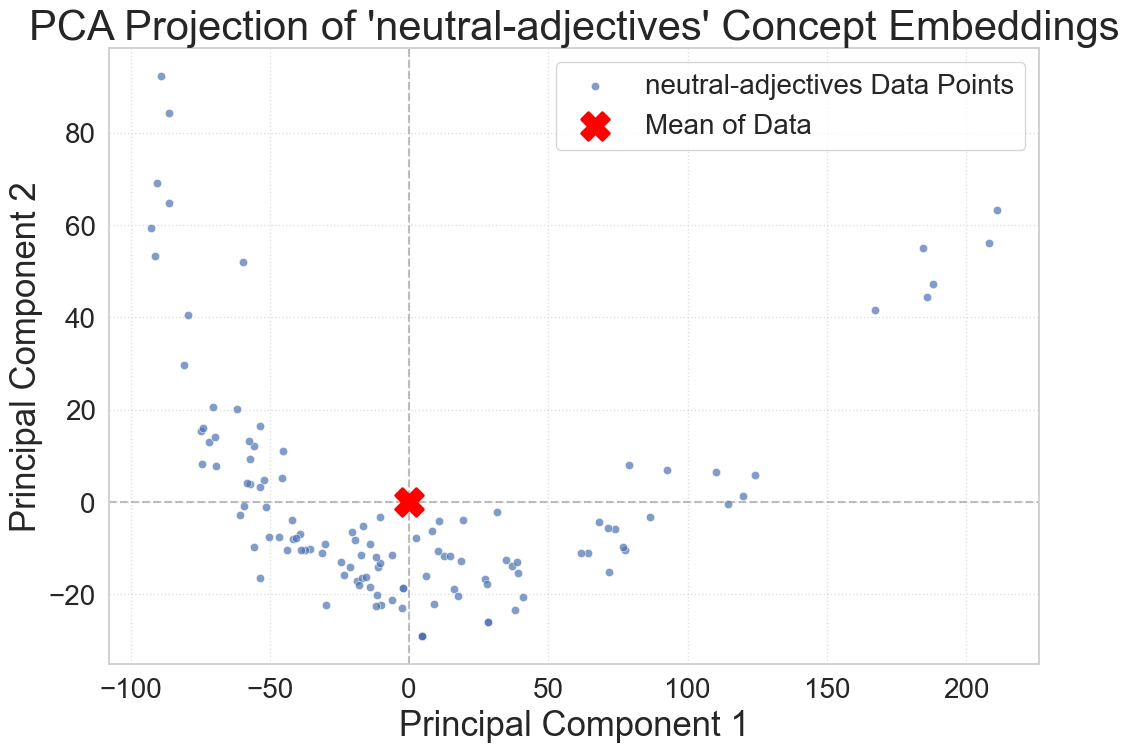

Layer: hidden_6 — Concept: positive-adjectives
Assumption HOLDS for 'male' concept. Plotting distribution...


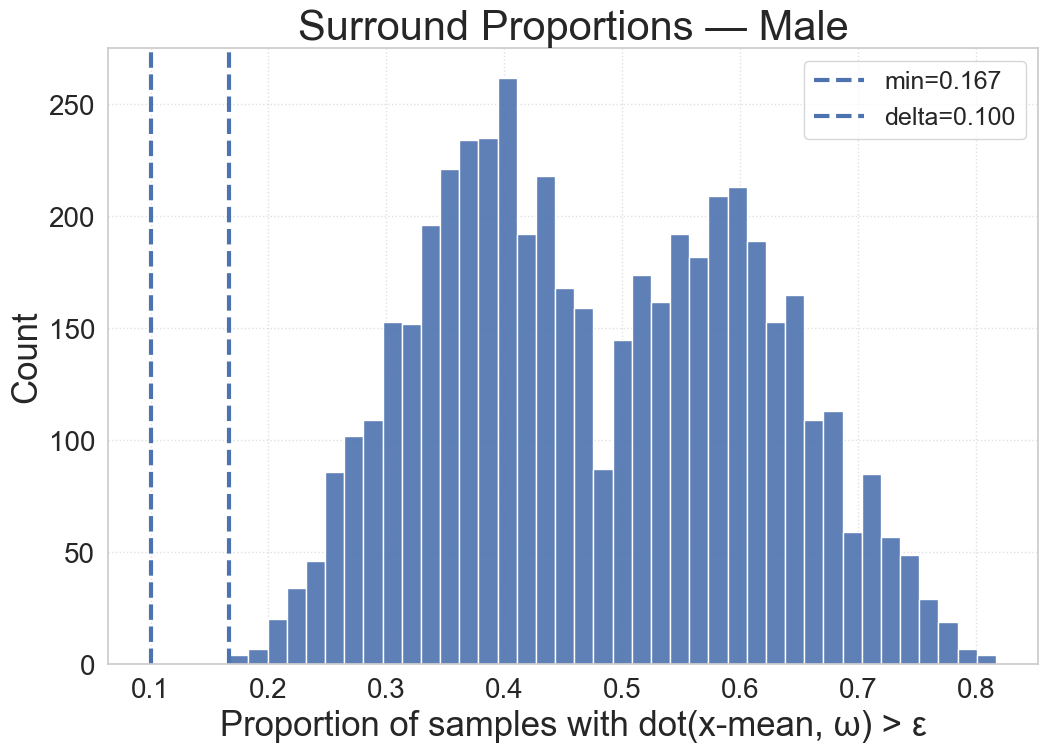

Generating PCA projection plot with larger fonts...


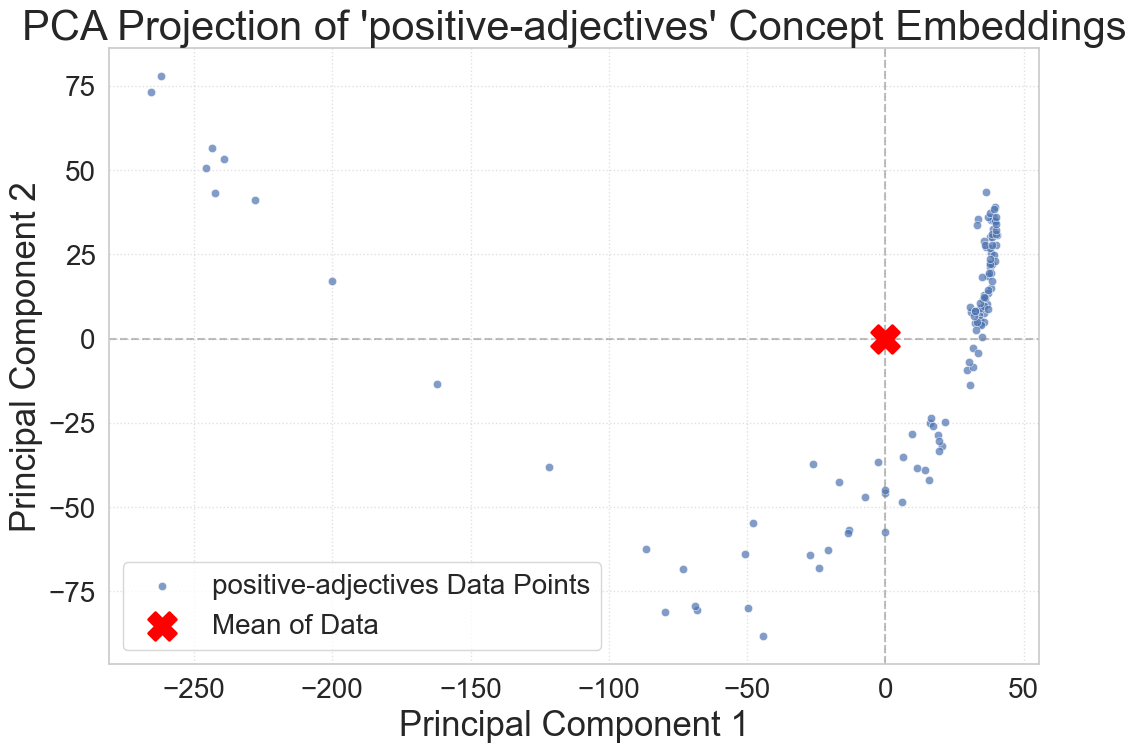

Layer: hidden_6 — Concept: negative-adjectives
Assumption HOLDS for 'male' concept. Plotting distribution...


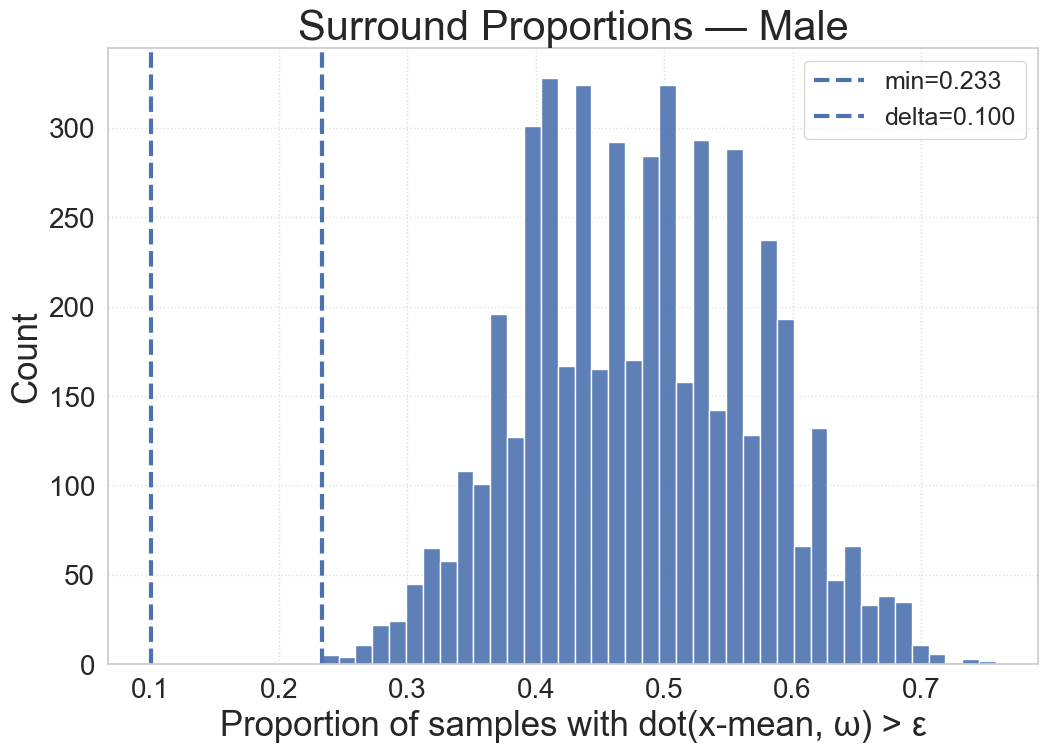

Generating PCA projection plot with larger fonts...


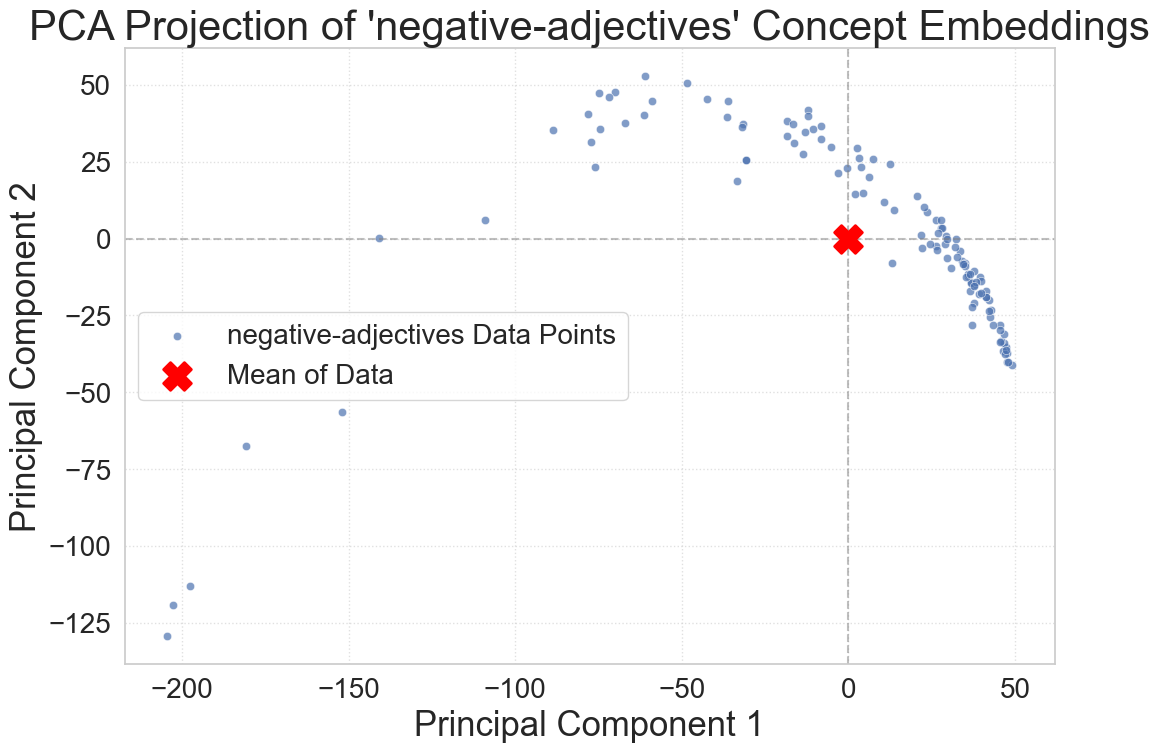

Layer: hidden_6 — Concept: neutral-adjectives
Assumption HOLDS for 'male' concept. Plotting distribution...


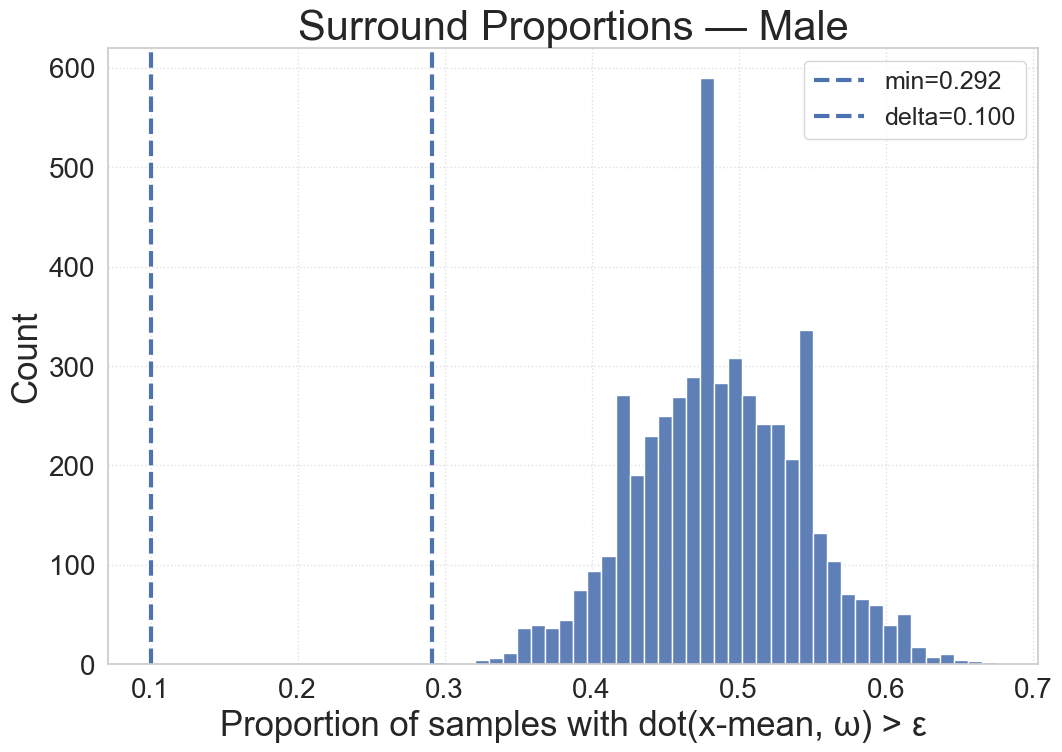

Generating PCA projection plot with larger fonts...


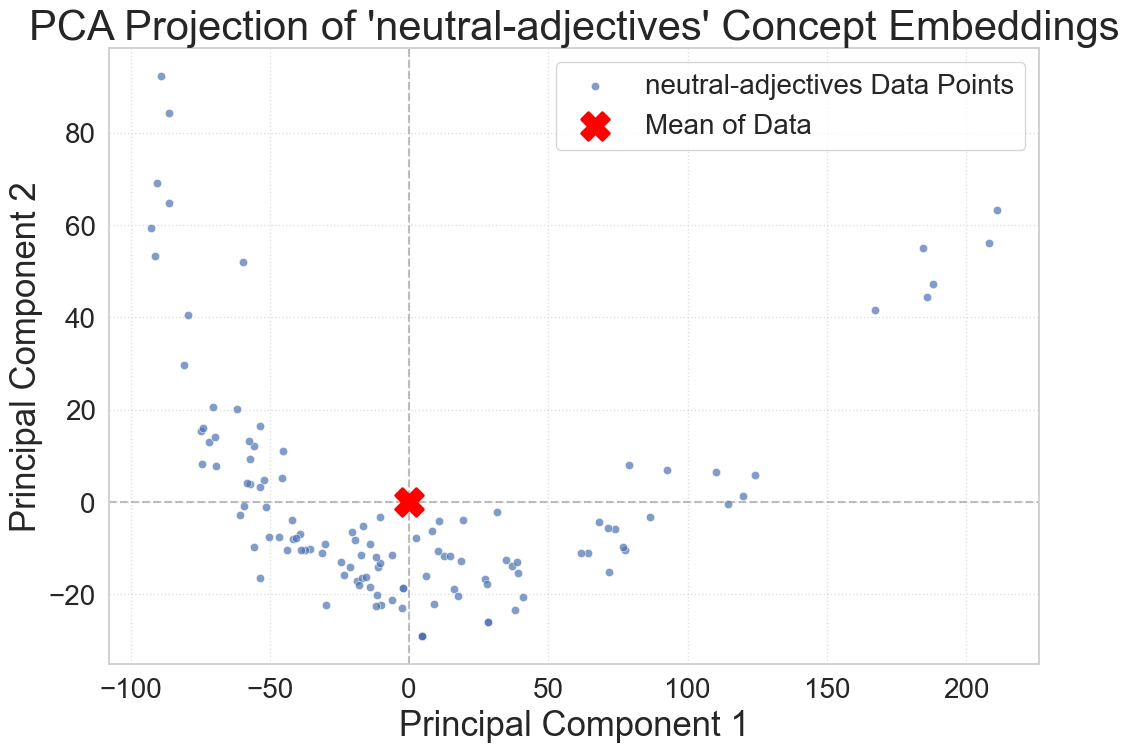

In [14]:
omegas_per_layer = {}

epsilon = 0.01
delta = 0.10

for layer in layer_names:
    for concept in cfg.dataset.concepts:
        print(f"Layer: {layer} — Concept: {concept}")
        pos_acts = activations_from_texts(concept_texts[concept], layer_index)
        neg_acts = activations_from_texts(random_texts, layer_index)
        concept_holds, concept_min_prop, concept_proportions = check_surround_assumption(
            pos_acts, epsilon=epsilon, delta=delta
        )
        if concept_holds:
            print(f"Assumption HOLDS for 'male' concept. Plotting distribution...")
            plot_surround_assumption(concept_proportions, concept_min_prop, delta, 'Male')
        else:
            print(f"Assumption FAILS for 'male' concept.")

        print("Generating PCA projection plot with larger fonts...")
        plot_pca_projection(pos_acts, concept)